Group Members

Arda Kaykusuz 20230766

Arif Maharramov 20230770

Yasmine Boubezari 20230775

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install highway-env
!pip install stable_baselines3
!pip install optuna
import gymnasium as gym
import highway_env

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

## Initial Grid Check with Low time

In [ ]:
import gymnasium as gym
import highway_env
from stable_baselines3 import DQN, PPO, SAC, A2C, DDPG, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import time
import pandas as pd

models = {
    "PPO": PPO,
    "A2C": A2C,
    "SAC": SAC,
    "DDPG": DDPG,
    "DQN": DQN,
    "TD3": TD3
}

actions = ["ContinuousAction", "DiscreteMetaAction"]
observations = [ "GrayscaleObservation", "OccupancyGrid", "TimeToCollision", "Kinematics",]
collision_rewards = [-1, -0.5, -0.1]
reward_speed_ranges = [[20, 30], [15, 25], [10, 20]]
simulation_frequencies = [15, 20]
policy_frequencies = [1, 2]

configuration = {
    # Parametrization bellow cannot be changed
    "lanes_count": 4, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -1,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15,  # [Hz] (Can be changed)
    "policy_frequency": 1,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

def train_and_evaluate(model_class, env, total_timesteps, num_episodes):
    model = model_class('MlpPolicy', env, verbose=0)
    model.learn(total_timesteps=total_timesteps)
    rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _states = model.predict(obs)
            step_result = env.step(action)
            if len(step_result) == 4:
                obs, reward, done, info = step_result
                truncated = False
            else:
                obs, reward, done, truncated, info = step_result
            total_reward += reward
            if done or truncated:
                break
        rewards.append(total_reward)
    average_reward = np.mean(rewards)
    return average_reward

results = []
total_timesteps = 500
num_episodes = 5

for model_name, model_class in models.items():
        for observation in observations:
            for collision_reward in collision_rewards:
                for reward_speed_range in reward_speed_ranges:
                    for sim_frequency in simulation_frequencies:
                        for policy_frequency in policy_frequencies:
                            try:
                                configuration["observation"]["type"] = observation
                                if observation == "GrayscaleObservation":
                                    configuration["observation"].update({
                                        "weights": [0.2989, 0.5870, 0.1140],
                                        "stack_size": 4,
                                        "observation_shape": (42, 42)
                                    })
                                configuration["action"]["type"] = action
                                configuration["collision_reward"] = collision_reward
                                configuration["reward_speed_range"] = reward_speed_range
                                configuration["simulation_frequency"] = sim_frequency
                                configuration["policy_frequency"] = policy_frequency
                                env = gym.make('highway-v0', config=configuration)
                                env = DummyVecEnv([lambda: env])

                                start_time = time.time()
                                average_reward = train_and_evaluate(model_class, env, total_timesteps, num_episodes)
                                end_time = time.time()
                                elapsed_time = end_time - start_time
                                results.append({
                                    "model": model_name,
                                    "action": action,
                                    "observation": observation,
                                    "collision_reward": collision_reward,
                                    "reward_speed_range": reward_speed_range,
                                    "simulation_frequency": sim_frequency,
                                    "policy_frequency": policy_frequency,
                                    "average_reward": average_reward,
                                    "elapsed_time": elapsed_time
                                })
                                print(f"Trained {model_name} with {action}, {observation}, collision_reward={collision_reward}, reward_speed_range={reward_speed_range}, sim_frequency={sim_frequency}, policy_frequency={policy_frequency} - Average Reward: {average_reward}, Time: {elapsed_time}s")
                            except Exception as e:
                                print(f"Failed to train {model_name} with {action}, {observation}, collision_reward={collision_reward}, reward_speed_range={reward_speed_range}, sim_frequency={sim_frequency}, policy_frequency={policy_frequency} - Error: {str(e)}")

results.sort(key=lambda x: x['average_reward'], reverse=True)
best_results = results[:10]
best_results_df = pd.DataFrame(best_results)
print(best_results_df)


## DQN DiscreteMetaAction TimeToCollision

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import highway_env
from stable_baselines3 import DQN, A2C, DDPG, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import time
import imageio

results = []

def optimize_hyperparameters(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    buffer_size = trial.suggest_int('buffer_size', 5000, 15000, 30000)
    learning_starts = trial.suggest_int('learning_starts', 200, 500)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    gamma = trial.suggest_uniform('gamma', 0.70, 0.90)
    train_freq = trial.suggest_int('train_freq', 1, 10)
    gradient_steps = trial.suggest_int('gradient_steps', 1, 10)
    target_update_interval = trial.suggest_int('target_update_interval', 10, 100)

    configuration = {
        "lanes_count": 4,
        "vehicles_count": 50,
        "duration": 120,
        "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
        "initial_spacing": 2,
        "observation": {
            "type": "TimeToCollision"
        },
        "action": {
            "type": "DiscreteMetaAction",
        },
        "collision_reward": -0.5,
        "reward_speed_range": [10, 20],
        "simulation_frequency": 15,
        "policy_frequency": 2,
        "screen_width": 800,
        "screen_height": 600,
        "centering_position": [0.5, 0.5],
        "scaling": 5,
        "show_trajectories": False,
        "render_agent": True,
        "offscreen_rendering": False
    }

    env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
    env = DummyVecEnv([lambda: env])

    model = DQN('MlpPolicy', env, learning_rate=learning_rate,
                        buffer_size=buffer_size, learning_starts=learning_starts,
                        batch_size=batch_size, gamma=gamma,
                        train_freq=train_freq, gradient_steps=gradient_steps,
                        target_update_interval=target_update_interval,
                        verbose=1)

    model.learn(total_timesteps=1000)
    rewards = []
    for _ in range(5):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            if len(step_result) == 4:
                obs, reward, done, info = step_result
                truncated = False
            else:
                obs, reward, done, truncated, info = step_result
            total_reward += reward
            if done or truncated:
                break
        rewards.append(total_reward)
    average_reward = np.mean(rewards)

    results.append({
        "model": "DQN",
        "learning_rate": learning_rate,
        "buffer_size": buffer_size,
        "learning_starts": learning_starts,
        "batch_size": batch_size,
        "gamma": gamma,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "target_update_interval": target_update_interval,
        "average_reward": average_reward
    })

    return average_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_hyperparameters, n_trials=50)
best_params = study.best_params

results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hyperparameter_tuning_results.csv", index=False)




[I 2024-06-12 16:25:19,370] A new study created in memory with name: no-name-585da948-5217-4073-80c7-9e17a992fd07
<ipython-input-3-a7da081e3c60>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-3-a7da081e3c60>:20: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  buffer_size = trial.suggest_int('buffer_size', 5000, 15000, 30000)
<ipython-input-3-a7da081e3c60>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.70, 0.90)


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 16       |
|    total_timesteps  | 103      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 29       |
|    total_timesteps  | 186      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 50       |
|    total_timesteps  | 314      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:30:39,901] Trial 0 finished with value: 185.75332641601562 and parameters: {'learning_rate': 0.002713613186711231, 'buffer_size': 5000, 'learning_starts': 357, 'batch_size': 256, 'gamma': 0.8994738463301484, 'train_freq': 1, 'gradient_steps': 3, 'target_update_interval': 100}. Best is trial 0 with value: 185.75332641601562.
<ipython-input-3-a7da081e3c60>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-3-a7da081e3c60>:20: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  buffer_size = trial.suggest_int('buffer_size', 5000, 15000, 30000)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 23       |
|    total_timesteps  | 152      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 34       |
|    total_timesteps  | 220      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 93       |
|    total_timesteps  | 586      |
| train/              |          |
|    learning_rate    | 0.000291 |
|  

[I 2024-06-12 16:33:48,334] Trial 1 finished with value: 14.03974437713623 and parameters: {'learning_rate': 0.0002906075617405554, 'buffer_size': 5000, 'learning_starts': 245, 'batch_size': 256, 'gamma': 0.7212384796551538, 'train_freq': 4, 'gradient_steps': 1, 'target_update_interval': 34}. Best is trial 0 with value: 185.75332641601562.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 84       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 139      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 35       |
|    total_timesteps  | 227      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:38:13,549] Trial 2 finished with value: 120.82594299316406 and parameters: {'learning_rate': 0.00010608918691039479, 'buffer_size': 5000, 'learning_starts': 420, 'batch_size': 256, 'gamma': 0.7854716086748167, 'train_freq': 2, 'gradient_steps': 6, 'target_update_interval': 37}. Best is trial 0 with value: 185.75332641601562.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.373    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 10       |
|    total_timesteps  | 66       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 30       |
|    total_timesteps  | 195      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 44       |
|    total_timesteps  | 279      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:41:52,094] Trial 3 finished with value: 60.64714813232422 and parameters: {'learning_rate': 3.966682462008537e-05, 'buffer_size': 5000, 'learning_starts': 434, 'batch_size': 64, 'gamma': 0.8539490834102543, 'train_freq': 1, 'gradient_steps': 7, 'target_update_interval': 61}. Best is trial 0 with value: 185.75332641601562.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.316    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 11       |
|    total_timesteps  | 72       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 29       |
|    total_timesteps  | 186      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 37       |
|    total_timesteps  | 235      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:47:47,050] Trial 4 finished with value: 227.465576171875 and parameters: {'learning_rate': 0.008392546915777612, 'buffer_size': 5000, 'learning_starts': 429, 'batch_size': 128, 'gamma': 0.8800049916053586, 'train_freq': 3, 'gradient_steps': 9, 'target_update_interval': 89}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 14       |
|    total_timesteps  | 93       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 25       |
|    total_timesteps  | 158      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 247      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:51:11,934] Trial 5 finished with value: 49.310638427734375 and parameters: {'learning_rate': 3.935229481439616e-05, 'buffer_size': 5000, 'learning_starts': 451, 'batch_size': 128, 'gamma': 0.7842829880917273, 'train_freq': 1, 'gradient_steps': 3, 'target_update_interval': 45}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 5        |
|    total_timesteps  | 35       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 12       |
|    total_timesteps  | 77       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 31       |
|    total_timesteps  | 198      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 16:54:18,062] Trial 6 finished with value: 31.72164535522461 and parameters: {'learning_rate': 0.0005223683605747709, 'buffer_size': 5000, 'learning_starts': 414, 'batch_size': 64, 'gamma': 0.7787514774549157, 'train_freq': 10, 'gradient_steps': 2, 'target_update_interval': 50}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 24       |
|    total_timesteps  | 154      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 249      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 87       |
|    total_timesteps  | 539      |
| train/              |          |
|    learning_rate    | 4.25e-05 |
|  

[I 2024-06-12 16:59:00,291] Trial 7 finished with value: 141.89974975585938 and parameters: {'learning_rate': 4.253393044980934e-05, 'buffer_size': 5000, 'learning_starts': 263, 'batch_size': 256, 'gamma': 0.8209703839963737, 'train_freq': 1, 'gradient_steps': 2, 'target_update_interval': 37}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 20       |
|    total_timesteps  | 125      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 249      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 50       |
|    total_timesteps  | 317      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:02:03,199] Trial 8 finished with value: 18.63999366760254 and parameters: {'learning_rate': 1.4321962151769074e-05, 'buffer_size': 5000, 'learning_starts': 344, 'batch_size': 128, 'gamma': 0.8787622667433703, 'train_freq': 2, 'gradient_steps': 9, 'target_update_interval': 64}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 8        |
|    total_timesteps  | 55       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 143      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 42       |
|    total_timesteps  | 266      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:04:52,956] Trial 9 finished with value: 9.799997329711914 and parameters: {'learning_rate': 9.021841773570057e-05, 'buffer_size': 5000, 'learning_starts': 272, 'batch_size': 256, 'gamma': 0.8233073510881528, 'train_freq': 7, 'gradient_steps': 4, 'target_update_interval': 39}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 21       |
|    total_timesteps  | 134      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 34       |
|    total_timesteps  | 214      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 43       |
|    total_timesteps  | 273      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:09:36,201] Trial 10 finished with value: 149.56480407714844 and parameters: {'learning_rate': 0.00770402236802726, 'buffer_size': 5000, 'learning_starts': 489, 'batch_size': 128, 'gamma': 0.7260104212422895, 'train_freq': 5, 'gradient_steps': 10, 'target_update_interval': 94}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 17       |
|    total_timesteps  | 110      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 36       |
|    total_timesteps  | 227      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 48       |
|    total_timesteps  | 306      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:13:23,957] Trial 11 finished with value: 79.44031524658203 and parameters: {'learning_rate': 0.009507097532007215, 'buffer_size': 5000, 'learning_starts': 348, 'batch_size': 128, 'gamma': 0.8962334420692125, 'train_freq': 4, 'gradient_steps': 8, 'target_update_interval': 99}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.392    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 10       |
|    total_timesteps  | 64       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 29       |
|    total_timesteps  | 187      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 43       |
|    total_timesteps  | 275      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:17:57,502] Trial 12 finished with value: 132.26817321777344 and parameters: {'learning_rate': 0.0015109202094105564, 'buffer_size': 5000, 'learning_starts': 375, 'batch_size': 256, 'gamma': 0.8573211991784772, 'train_freq': 3, 'gradient_steps': 5, 'target_update_interval': 81}. Best is trial 4 with value: 227.465576171875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 7        |
|    total_timesteps  | 49       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 23       |
|    total_timesteps  | 147      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 54       |
|    total_timesteps  | 339      |
| train/              |          |
|    learning_rate    | 0.00255  |
|  

[I 2024-06-12 17:23:48,198] Trial 13 finished with value: 234.46066284179688 and parameters: {'learning_rate': 0.0025512430196950827, 'buffer_size': 5000, 'learning_starts': 311, 'batch_size': 128, 'gamma': 0.8993440470648632, 'train_freq': 7, 'gradient_steps': 5, 'target_update_interval': 80}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.278    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 12       |
|    total_timesteps  | 76       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 26       |
|    total_timesteps  | 168      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 34       |
|    total_timesteps  | 219      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:29:38,368] Trial 14 finished with value: 234.15457153320312 and parameters: {'learning_rate': 0.0030488409744210284, 'buffer_size': 5000, 'learning_starts': 312, 'batch_size': 128, 'gamma': 0.8626595100743566, 'train_freq': 7, 'gradient_steps': 6, 'target_update_interval': 12}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.221    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 82       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 25       |
|    total_timesteps  | 160      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 41       |
|    total_timesteps  | 265      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:33:45,853] Trial 15 finished with value: 107.60357666015625 and parameters: {'learning_rate': 0.0017324248112883403, 'buffer_size': 5000, 'learning_starts': 300, 'batch_size': 128, 'gamma': 0.8415380648981998, 'train_freq': 8, 'gradient_steps': 6, 'target_update_interval': 21}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.601    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 6        |
|    total_timesteps  | 42       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 21       |
|    total_timesteps  | 133      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 100      |
|    total_timesteps  | 633      |
| train/              |          |
|    learning_rate    | 0.000687 |
|  

[I 2024-06-12 17:39:36,228] Trial 16 finished with value: 222.0351104736328 and parameters: {'learning_rate': 0.0006867402777799498, 'buffer_size': 5000, 'learning_starts': 210, 'batch_size': 128, 'gamma': 0.871922607449847, 'train_freq': 7, 'gradient_steps': 7, 'target_update_interval': 12}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 7        |
|    total_timesteps  | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 33       |
|    total_timesteps  | 210      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 45       |
|    total_timesteps  | 291      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:44:14,552] Trial 17 finished with value: 138.92880249023438 and parameters: {'learning_rate': 0.0036314013125922926, 'buffer_size': 5000, 'learning_starts': 307, 'batch_size': 128, 'gamma': 0.7480230050156503, 'train_freq': 9, 'gradient_steps': 5, 'target_update_interval': 71}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 7        |
|    total_timesteps  | 49       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 24       |
|    total_timesteps  | 153      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 41       |
|    total_timesteps  | 257      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 17:50:04,175] Trial 18 finished with value: 220.7979278564453 and parameters: {'learning_rate': 0.0008613694434258714, 'buffer_size': 5000, 'learning_starts': 311, 'batch_size': 64, 'gamma': 0.8261605028027535, 'train_freq': 6, 'gradient_steps': 4, 'target_update_interval': 80}. Best is trial 13 with value: 234.46066284179688.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 11       |
|    total_timesteps  | 71       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 182      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 252      |
| train/              |          |
|    learning_rate    | 0.00422  |
|  

[I 2024-06-12 17:55:53,546] Trial 19 finished with value: 239.43295288085938 and parameters: {'learning_rate': 0.004222028169411221, 'buffer_size': 5000, 'learning_starts': 226, 'batch_size': 128, 'gamma': 0.8623761338313086, 'train_freq': 8, 'gradient_steps': 7, 'target_update_interval': 25}. Best is trial 19 with value: 239.43295288085938.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.069    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 15       |
|    total_timesteps  | 98       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 26       |
|    total_timesteps  | 168      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 71       |
|    total_timesteps  | 449      |
| train/              |          |
|    learning_rate    | 0.00026  |
|  

[I 2024-06-12 18:01:44,143] Trial 20 finished with value: 239.7679443359375 and parameters: {'learning_rate': 0.00026012140510942516, 'buffer_size': 5000, 'learning_starts': 212, 'batch_size': 128, 'gamma': 0.8068385987025072, 'train_freq': 9, 'gradient_steps': 7, 'target_update_interval': 26}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 12       |
|    total_timesteps  | 81       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 182      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 80       |
|    total_timesteps  | 508      |
| train/              |          |
|    learning_rate    | 0.000177 |
|  

[I 2024-06-12 18:06:36,385] Trial 21 finished with value: 159.3385772705078 and parameters: {'learning_rate': 0.00017702108699274555, 'buffer_size': 5000, 'learning_starts': 201, 'batch_size': 128, 'gamma': 0.8034220204624416, 'train_freq': 9, 'gradient_steps': 7, 'target_update_interval': 25}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 19       |
|    total_timesteps  | 126      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 31       |
|    total_timesteps  | 203      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 53       |
|    total_timesteps  | 339      |
| train/              |          |
|    learning_rate    | 0.000299 |
|  

[I 2024-06-12 18:10:45,320] Trial 22 finished with value: 105.8143310546875 and parameters: {'learning_rate': 0.0002990972029121714, 'buffer_size': 5000, 'learning_starts': 229, 'batch_size': 128, 'gamma': 0.7579088241554526, 'train_freq': 10, 'gradient_steps': 8, 'target_update_interval': 27}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 139      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 33       |
|    total_timesteps  | 208      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 51       |
|    total_timesteps  | 320      |
| train/              |          |
|    learning_rate    | 0.00131  |
|  

[I 2024-06-12 18:14:05,179] Trial 23 finished with value: 47.32048034667969 and parameters: {'learning_rate': 0.001306812859779599, 'buffer_size': 5000, 'learning_starts': 234, 'batch_size': 128, 'gamma': 0.8408570022997339, 'train_freq': 8, 'gradient_steps': 8, 'target_update_interval': 54}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 18       |
|    total_timesteps  | 119      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 49       |
|    total_timesteps  | 310      |
| train/              |          |
|    learning_rate    | 0.00467  |
|    loss             | 0.283    |
|    n_updates        | 25       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|  

[I 2024-06-12 18:18:15,482] Trial 24 finished with value: 113.19254302978516 and parameters: {'learning_rate': 0.0046677642993412745, 'buffer_size': 5000, 'learning_starts': 268, 'batch_size': 128, 'gamma': 0.8860578493556645, 'train_freq': 8, 'gradient_steps': 5, 'target_update_interval': 16}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 27       |
|    total_timesteps  | 175      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 34       |
|    total_timesteps  | 216      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 44       |
|    total_timesteps  | 281      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 18:23:32,580] Trial 25 finished with value: 192.39590454101562 and parameters: {'learning_rate': 0.00043935738533832074, 'buffer_size': 5000, 'learning_starts': 282, 'batch_size': 64, 'gamma': 0.8046690653622269, 'train_freq': 9, 'gradient_steps': 7, 'target_update_interval': 73}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 18       |
|    total_timesteps  | 120      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 38       |
|    total_timesteps  | 245      |
| train/              |          |
|    learning_rate    | 0.000935 |
|    loss             | 0.342    |
|    n_updates        | 16       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|  

[I 2024-06-12 18:28:46,355] Trial 26 finished with value: 175.17532348632812 and parameters: {'learning_rate': 0.0009352985353766474, 'buffer_size': 5000, 'learning_starts': 217, 'batch_size': 128, 'gamma': 0.8348442903480614, 'train_freq': 6, 'gradient_steps': 4, 'target_update_interval': 26}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 9        |
|    total_timesteps  | 60       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 31       |
|    total_timesteps  | 200      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 101      |
|    total_timesteps  | 637      |
| train/              |          |
|    learning_rate    | 0.00572  |
|  

[I 2024-06-12 18:34:00,421] Trial 27 finished with value: 188.52450561523438 and parameters: {'learning_rate': 0.0057234767952498555, 'buffer_size': 5000, 'learning_starts': 256, 'batch_size': 128, 'gamma': 0.7015184492821885, 'train_freq': 8, 'gradient_steps': 9, 'target_update_interval': 45}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 85       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 182      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 56       |
|    total_timesteps  | 360      |
| train/              |          |
|    learning_rate    | 0.00186  |
|  

[I 2024-06-12 18:39:49,502] Trial 28 finished with value: 238.4741668701172 and parameters: {'learning_rate': 0.001862328624389024, 'buffer_size': 5000, 'learning_starts': 289, 'batch_size': 128, 'gamma': 0.8657890505087684, 'train_freq': 10, 'gradient_steps': 6, 'target_update_interval': 32}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.164    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 88       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 24       |
|    total_timesteps  | 155      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 252      |
| train/              |          |
|    learning_rate    | 0.00227  |
|  

[I 2024-06-12 18:45:06,124] Trial 29 finished with value: 192.93673706054688 and parameters: {'learning_rate': 0.0022690118175043403, 'buffer_size': 5000, 'learning_starts': 239, 'batch_size': 64, 'gamma': 0.8119063815177947, 'train_freq': 10, 'gradient_steps': 6, 'target_update_interval': 31}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.126    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 14       |
|    total_timesteps  | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 40       |
|    total_timesteps  | 255      |
| train/              |          |
|    learning_rate    | 0.000167 |
|    loss             | 0.432    |
|    n_updates        | 48       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|  

[I 2024-06-12 18:49:22,088] Trial 30 finished with value: 108.97457122802734 and parameters: {'learning_rate': 0.0001674092407728219, 'buffer_size': 5000, 'learning_starts': 202, 'batch_size': 128, 'gamma': 0.8524172290936249, 'train_freq': 9, 'gradient_steps': 8, 'target_update_interval': 20}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0595   |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 15       |
|    total_timesteps  | 99       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 29       |
|    total_timesteps  | 184      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 44       |
|    total_timesteps  | 280      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 18:54:40,154] Trial 31 finished with value: 191.41921997070312 and parameters: {'learning_rate': 0.0025762164119142823, 'buffer_size': 5000, 'learning_starts': 289, 'batch_size': 128, 'gamma': 0.8919462474318683, 'train_freq': 10, 'gradient_steps': 5, 'target_update_interval': 44}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 84       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 179      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 61       |
|    total_timesteps  | 387      |
| train/              |          |
|    learning_rate    | 0.00498  |
|  

[I 2024-06-12 18:57:44,535] Trial 32 finished with value: 31.160791397094727 and parameters: {'learning_rate': 0.004984490842663812, 'buffer_size': 5000, 'learning_starts': 334, 'batch_size': 128, 'gamma': 0.8692064631342268, 'train_freq': 7, 'gradient_steps': 7, 'target_update_interval': 20}. Best is trial 20 with value: 239.7679443359375.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.335    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 11       |
|    total_timesteps  | 70       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 27       |
|    total_timesteps  | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 38       |
|    total_timesteps  | 245      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:03:36,095] Trial 33 finished with value: 239.7866668701172 and parameters: {'learning_rate': 0.0012419748252262897, 'buffer_size': 5000, 'learning_starts': 378, 'batch_size': 128, 'gamma': 0.8955574805089136, 'train_freq': 9, 'gradient_steps': 6, 'target_update_interval': 32}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.088    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 15       |
|    total_timesteps  | 96       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 177      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 247      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:08:51,276] Trial 34 finished with value: 195.1368865966797 and parameters: {'learning_rate': 0.0011583962022756315, 'buffer_size': 5000, 'learning_starts': 383, 'batch_size': 128, 'gamma': 0.8486492196761786, 'train_freq': 9, 'gradient_steps': 6, 'target_update_interval': 33}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.364    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 10       |
|    total_timesteps  | 67       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 27       |
|    total_timesteps  | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 38       |
|    total_timesteps  | 240      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:14:12,895] Trial 35 finished with value: 182.2254180908203 and parameters: {'learning_rate': 0.00043137461702753095, 'buffer_size': 5000, 'learning_starts': 389, 'batch_size': 256, 'gamma': 0.8688390596360236, 'train_freq': 10, 'gradient_steps': 7, 'target_update_interval': 30}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 15       |
|    total_timesteps  | 101      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 140      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 33       |
|    total_timesteps  | 211      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:17:32,560] Trial 36 finished with value: 44.78750991821289 and parameters: {'learning_rate': 0.00016701980102900414, 'buffer_size': 5000, 'learning_starts': 247, 'batch_size': 128, 'gamma': 0.7920237142491097, 'train_freq': 9, 'gradient_steps': 6, 'target_update_interval': 39}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 21       |
|    total_timesteps  | 136      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 44       |
|    total_timesteps  | 284      |
| train/              |          |
|    learning_rate    | 0.000682 |
|    loss             | 0.344    |
|    n_updates        | 56       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|  

[I 2024-06-12 19:23:22,798] Trial 37 finished with value: 228.0220184326172 and parameters: {'learning_rate': 0.0006821156173707855, 'buffer_size': 5000, 'learning_starts': 225, 'batch_size': 128, 'gamma': 0.87992024169466, 'train_freq': 8, 'gradient_steps': 8, 'target_update_interval': 17}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.44     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 9        |
|    total_timesteps  | 59       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 26       |
|    total_timesteps  | 166      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 43       |
|    total_timesteps  | 278      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:28:25,301] Trial 38 finished with value: 177.72177124023438 and parameters: {'learning_rate': 0.0018402240387216373, 'buffer_size': 5000, 'learning_starts': 404, 'batch_size': 64, 'gamma': 0.8855871274081045, 'train_freq': 10, 'gradient_steps': 7, 'target_update_interval': 49}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 18       |
|    total_timesteps  | 117      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 30       |
|    total_timesteps  | 195      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 50       |
|    total_timesteps  | 322      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:33:26,904] Trial 39 finished with value: 172.3777313232422 and parameters: {'learning_rate': 0.00023820704892830012, 'buffer_size': 5000, 'learning_starts': 329, 'batch_size': 256, 'gamma': 0.7697260288240939, 'train_freq': 9, 'gradient_steps': 10, 'target_update_interval': 34}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 8        |
|    total_timesteps  | 56       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 143      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 36       |
|    total_timesteps  | 230      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:36:28,035] Trial 40 finished with value: 23.1400089263916 and parameters: {'learning_rate': 0.00010402027555055535, 'buffer_size': 5000, 'learning_starts': 361, 'batch_size': 128, 'gamma': 0.8636951865334419, 'train_freq': 8, 'gradient_steps': 9, 'target_update_interval': 59}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 23       |
|    total_timesteps  | 152      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 39       |
|    total_timesteps  | 251      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 46       |
|    total_timesteps  | 297      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:42:17,976] Trial 41 finished with value: 239.39334106445312 and parameters: {'learning_rate': 0.00316378530671754, 'buffer_size': 5000, 'learning_starts': 361, 'batch_size': 128, 'gamma': 0.8969859005641448, 'train_freq': 6, 'gradient_steps': 5, 'target_update_interval': 24}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 6        |
|    total_timesteps  | 38       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 30       |
|    total_timesteps  | 190      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 52       |
|    total_timesteps  | 325      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:47:41,434] Trial 42 finished with value: 189.24179077148438 and parameters: {'learning_rate': 0.0039830840784722266, 'buffer_size': 5000, 'learning_starts': 364, 'batch_size': 128, 'gamma': 0.8871853851352657, 'train_freq': 5, 'gradient_steps': 4, 'target_update_interval': 26}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 28       |
|    total_timesteps  | 182      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 37       |
|    total_timesteps  | 236      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 46       |
|    total_timesteps  | 296      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:52:56,302] Trial 43 finished with value: 186.70034790039062 and parameters: {'learning_rate': 0.006099978248109554, 'buffer_size': 5000, 'learning_starts': 402, 'batch_size': 128, 'gamma': 0.8998100284363668, 'train_freq': 6, 'gradient_steps': 3, 'target_update_interval': 38}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 12       |
|    total_timesteps  | 80       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 25       |
|    total_timesteps  | 158      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 41       |
|    total_timesteps  | 257      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 19:56:19,399] Trial 44 finished with value: 53.441650390625 and parameters: {'learning_rate': 6.686700058710518e-05, 'buffer_size': 5000, 'learning_starts': 435, 'batch_size': 128, 'gamma': 0.8759195718201283, 'train_freq': 10, 'gradient_steps': 6, 'target_update_interval': 23}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 14       |
|    total_timesteps  | 89       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 23       |
|    total_timesteps  | 146      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 40       |
|    total_timesteps  | 251      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 20:00:32,716] Trial 45 finished with value: 112.8006820678711 and parameters: {'learning_rate': 0.0032570561657206793, 'buffer_size': 5000, 'learning_starts': 332, 'batch_size': 128, 'gamma': 0.8579810617455608, 'train_freq': 4, 'gradient_steps': 5, 'target_update_interval': 29}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.421    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 9        |
|    total_timesteps  | 61       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 22       |
|    total_timesteps  | 142      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 45       |
|    total_timesteps  | 287      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 20:06:23,606] Trial 46 finished with value: 231.99960327148438 and parameters: {'learning_rate': 1.6710303403570453e-05, 'buffer_size': 5000, 'learning_starts': 352, 'batch_size': 256, 'gamma': 0.8885612581267277, 'train_freq': 5, 'gradient_steps': 1, 'target_update_interval': 10}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.705    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 5        |
|    total_timesteps  | 31       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 16       |
|    total_timesteps  | 106      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 48       |
|    total_timesteps  | 308      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 20:12:15,817] Trial 47 finished with value: 236.8603057861328 and parameters: {'learning_rate': 0.0017721242924076085, 'buffer_size': 5000, 'learning_starts': 463, 'batch_size': 128, 'gamma': 0.8776301985416697, 'train_freq': 9, 'gradient_steps': 6, 'target_update_interval': 15}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 19       |
|    total_timesteps  | 121      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 78       |
|    total_timesteps  | 488      |
| train/              |          |
|    learning_rate    | 0.00822  |
|    loss             | 0.0303   |
|    n_updates        | 203      |
----------------------------------


[I 2024-06-12 20:15:57,421] Trial 48 finished with value: 73.19853973388672 and parameters: {'learning_rate': 0.008220871539216947, 'buffer_size': 5000, 'learning_starts': 253, 'batch_size': 128, 'gamma': 0.8316960407164038, 'train_freq': 8, 'gradient_steps': 7, 'target_update_interval': 42}. Best is trial 33 with value: 239.7866668701172.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 18       |
|    total_timesteps  | 119      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 41       |
|    total_timesteps  | 266      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6        |
|    time_elapsed     | 49       |
|    total_timesteps  | 314      |
----------------------------------
----------------------------------
| r

[I 2024-06-12 20:21:18,517] Trial 49 finished with value: 195.6510009765625 and parameters: {'learning_rate': 0.0005341191735542571, 'buffer_size': 5000, 'learning_starts': 370, 'batch_size': 128, 'gamma': 0.8463214265428102, 'train_freq': 3, 'gradient_steps': 4, 'target_update_interval': 35}. Best is trial 33 with value: 239.7866668701172.


KeyError: 'model'

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import seaborn as sns

configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "TimeToCollision"
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "collision_reward": -0.5,
    "reward_speed_range": [10, 20],
    "simulation_frequency": 15,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")

model = DQN('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]),
    learning_rate=0.001241975,
    buffer_size=5000,
    learning_starts=378,
    batch_size=128,
    gamma=0.895557481,
    train_freq=9,
    gradient_steps=6,
    target_update_interval=32,
    verbose=1,
    tensorboard_log="/content/drive/MyDrive/RL/highway_dqn",
)

TRAIN = True
total_timesteps=5000
if TRAIN:
        model.learn(total_timesteps=total_timesteps)
        model.save("/content/drive/MyDrive/RL/highway_dqn/model")
        del model

model = DQN.load("/content/drive/MyDrive/RL/highway_dqn/model", env=env)

env = RecordVideo(env, video_folder="/content/drive/MyDrive/RL/highway_dqn/video", episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
env.configure({"simulation_frequency": 30})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/RL/highway_dqn/DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 24       |
|    total_timesteps  | 145      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 32       |
|    total_timesteps  | 194      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len

Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-0.mp4
Total reward for episode 1: 78.6287381221734
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-1.mp4
Total reward for episode 2: 78.0057938191833
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-2.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-2.mp4
Total reward for episode 3: 78.41611801890485
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-3.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-3.mp4
Total reward for episode 4: 79.79433810776645
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-4.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-4.mp4
Total reward for episode 5: 78.26998126516477
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-5.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-5.mp4
Total reward for episode 6: 77.27868599442016
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-6.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-6.mp4
Total reward for episode 7: 78.10925992479663
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-7.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-7.mp4
Total reward for episode 8: 78.54469371771775
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-8.mp4
Total reward for episode 9: 78.3956228080435
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-9.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-9.mp4
Total reward for episode 10: 78.70219354251243
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-10.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-10.mp4
Total reward for episode 11: 72.89999999999998
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-11.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-11.mp4
Total reward for episode 12: 74.6666666666666
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-12.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-12.mp4
Total reward for episode 13: 77.76921620583022
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-13.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-13.mp4
Total reward for episode 14: 78.33098516674345
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-14.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-14.mp4
Total reward for episode 15: 78.95408729036863
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-15.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-15.mp4
Total reward for episode 16: 78.15376949641626
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-16.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-16.mp4
Total reward for episode 17: 79.33661970530413
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-17.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-17.mp4
Total reward for episode 18: 77.61198137638883
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-18.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-18.mp4
Total reward for episode 19: 78.15126703210655
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-19.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-19.mp4
Total reward for episode 20: 77.58720690066806
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-20.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-20.mp4
Total reward for episode 21: 78.05866925942361
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-21.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-21.mp4
Total reward for episode 22: 78.23931041638345
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-22.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-22.mp4
Total reward for episode 23: 77.79497380595144
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-23.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-23.mp4
Total reward for episode 24: 78.32752340695593
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-24.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-24.mp4
Total reward for episode 25: 77.00478372895834
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-25.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-25.mp4
Total reward for episode 26: 5.726313319607732
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-26.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-26.mp4
Total reward for episode 27: 77.82706417489175
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-27.mp4
Total reward for episode 28: 77.33333333333339
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-28.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-28.mp4
Total reward for episode 29: 77.60660951919968
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-29.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-29.mp4
Total reward for episode 30: 77.58488114637609


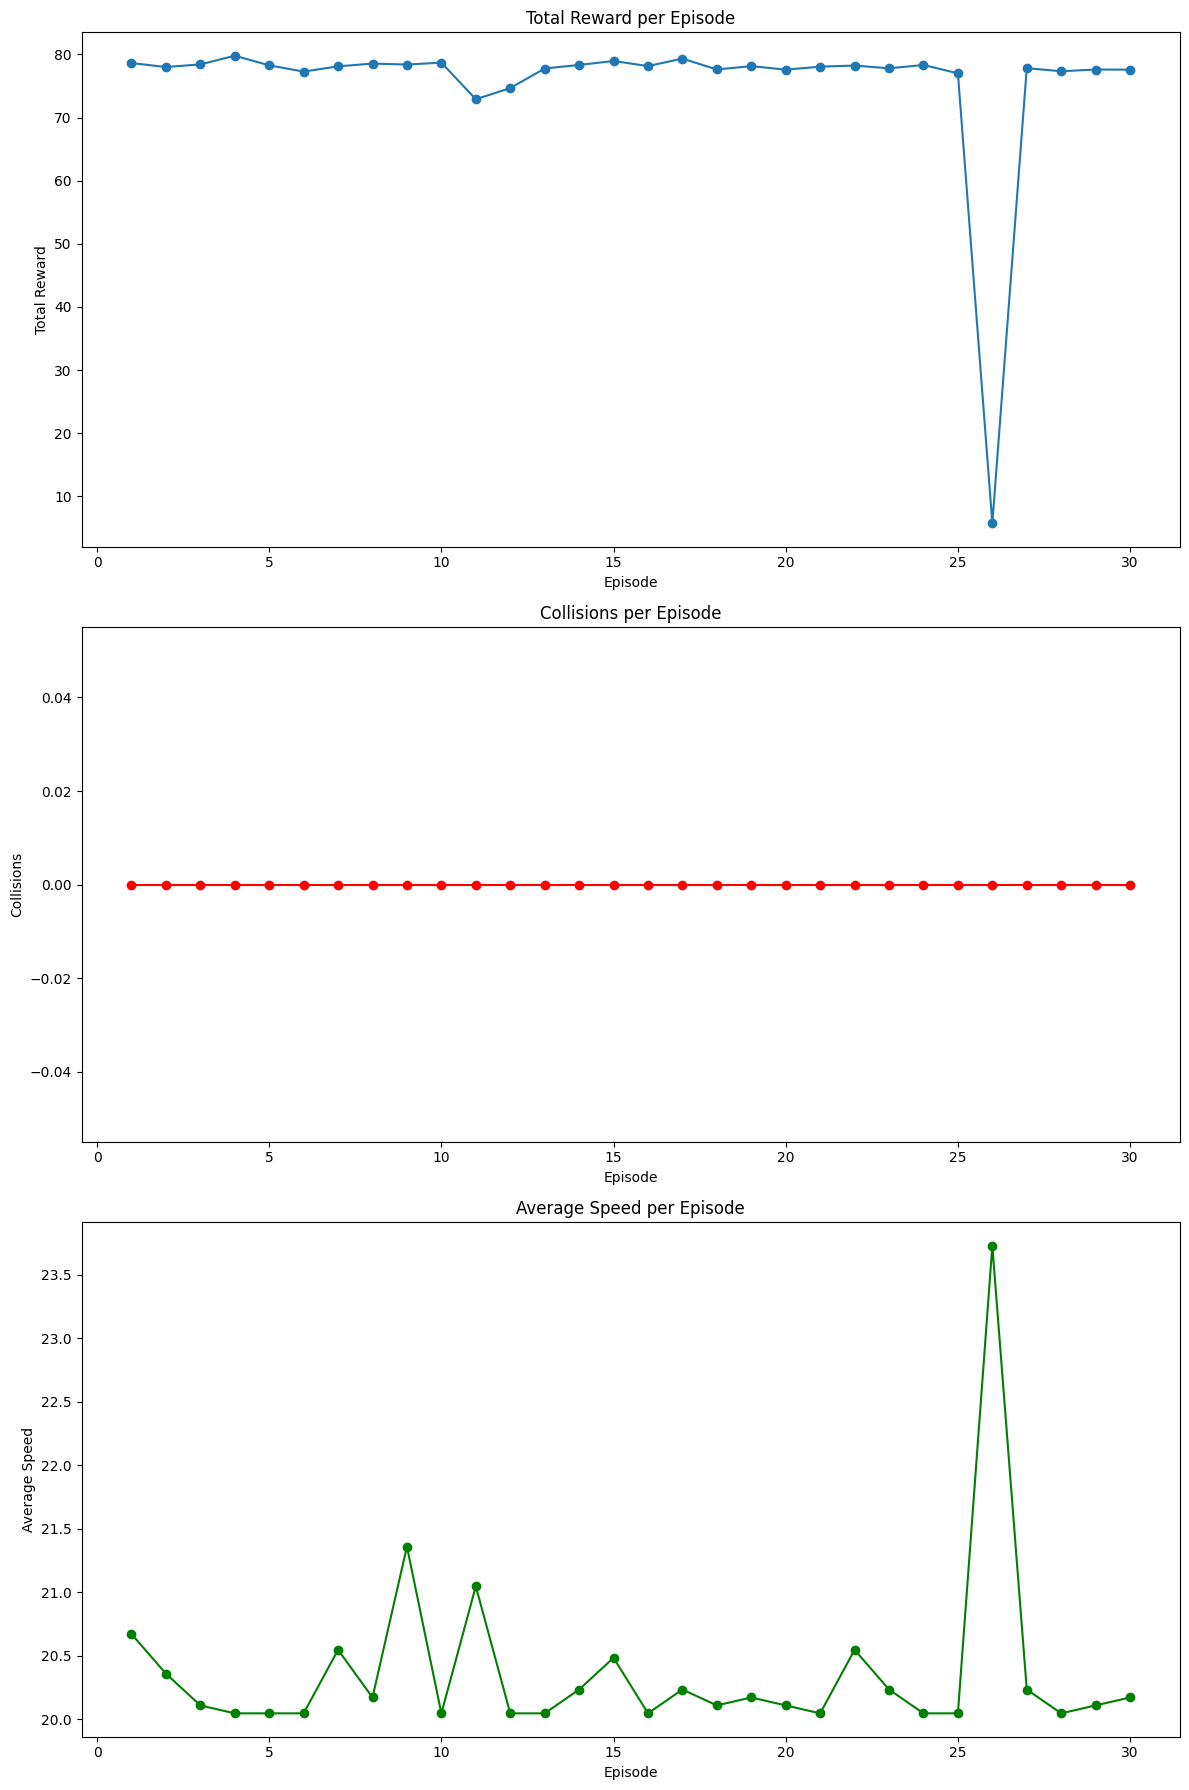

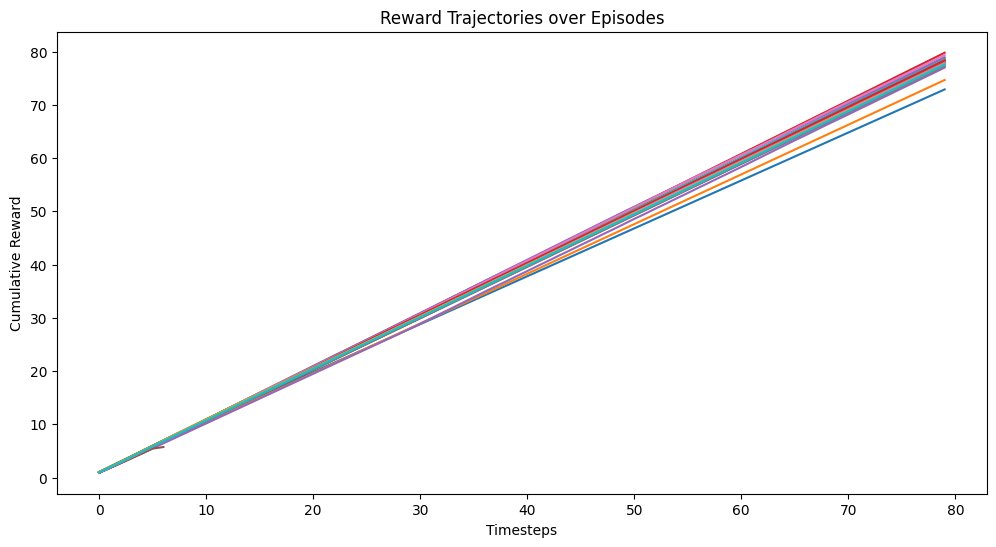

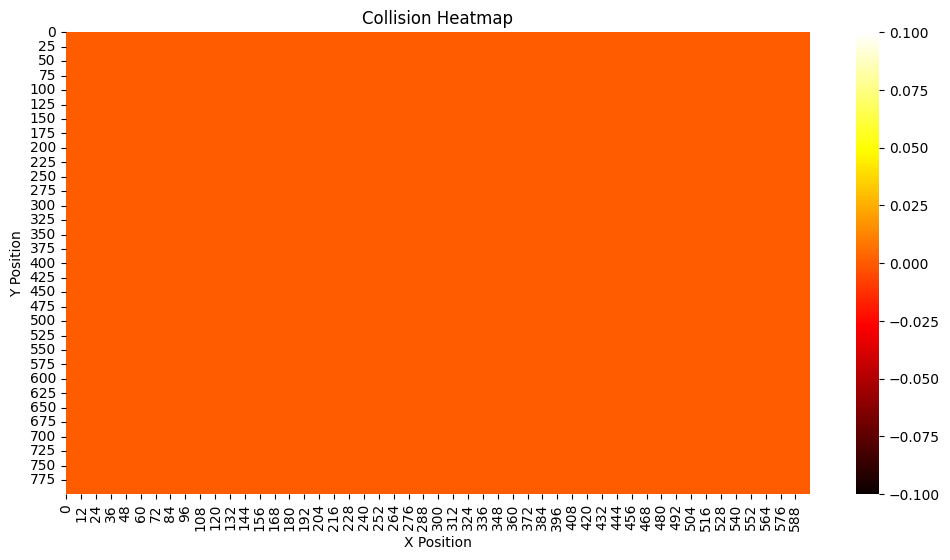

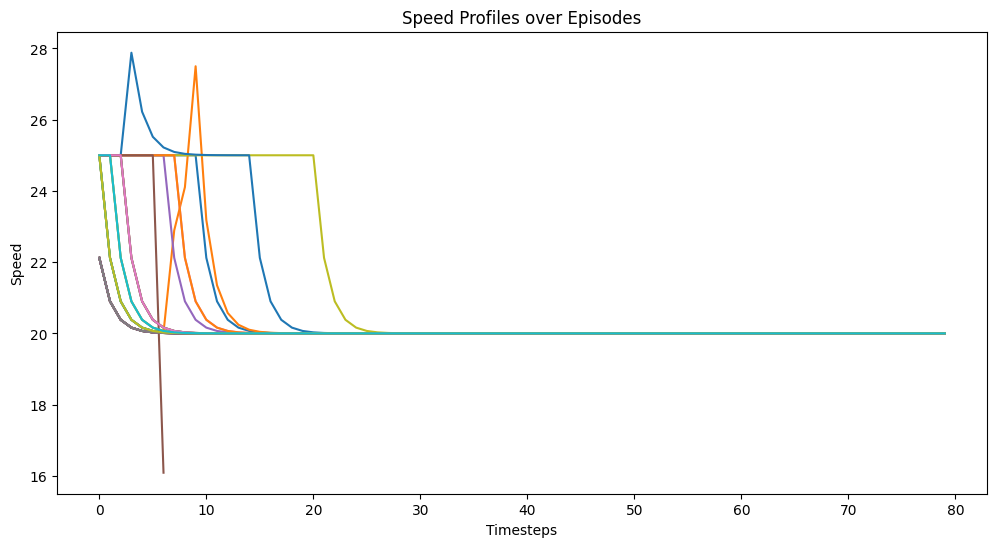

In [ ]:
num_episodes = 30
evaluation_metrics = {
    'episode': [],
    'total_reward': [],
    'collisions': [],
    'average_speed': [],
    'cumulative_rewards': [],
    'collision_positions': [],
    'speed_profiles': []
}

for episode in range(num_episodes):
    done = truncated = False
    obs, info = env.reset()
    total_reward = 0
    collisions = 0
    speeds = []
    cumulative_rewards = []
    collision_positions = []
    step_rewards = []
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        step_rewards.append(total_reward)
        speeds.append(info['speed'])
        if 'collision' in info and info['collision']:
            collisions += 1
            collision_positions.append(info['position'])
        env.render()
    evaluation_metrics['episode'].append(episode + 1)
    evaluation_metrics['total_reward'].append(total_reward)
    evaluation_metrics['collisions'].append(collisions)
    evaluation_metrics['average_speed'].append(np.mean(speeds))
    evaluation_metrics['cumulative_rewards'].append(step_rewards)
    evaluation_metrics['collision_positions'].append(collision_positions)
    evaluation_metrics['speed_profiles'].append(speeds)
    print(f"Total reward for episode {episode + 1}: {total_reward}")
env.close()

df_metrics = pd.DataFrame(evaluation_metrics)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(df_metrics['episode'], df_metrics['total_reward'], marker='o')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Total Reward per Episode')

axs[1].plot(df_metrics['episode'], df_metrics['collisions'], marker='o', color='r')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Collisions')
axs[1].set_title('Collisions per Episode')

axs[2].plot(df_metrics['episode'], df_metrics['average_speed'], marker='o', color='g')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Speed')
axs[2].set_title('Average Speed per Episode')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for rewards in df_metrics['cumulative_rewards']:
    plt.plot(rewards)
plt.xlabel('Timesteps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Trajectories over Episodes')
plt.show()

collision_heatmap = np.zeros((configuration['screen_width'], configuration['screen_height']))
for positions in df_metrics['collision_positions']:
    for pos in positions:
        collision_heatmap[int(pos[0]), int(pos[1])] += 1

plt.figure(figsize=(12, 6))
sns.heatmap(collision_heatmap, cmap='hot', cbar=True)
plt.title('Collision Heatmap')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

plt.figure(figsize=(12, 6))
for speeds in df_metrics['speed_profiles']:
    plt.plot(speeds)
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Speed Profiles over Episodes')
plt.show()


In [ ]:
from IPython.display import Video
video_path = "/content/drive/MyDrive/RL/highway_dqn/video/rl-video-episode-2.mp4"
Video(video_path, embed=True)

## DQN DiscreteMetaAction Kinematics

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import highway_env
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.dqn import MlpPolicy
import numpy as np
import pandas as pd
import optuna

results = []
total_timesteps = 5000
num_episodes = 5

def optimize_hyperparameters(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    buffer_size = trial.suggest_int('buffer_size', 5000, 30000, step=5000)
    learning_starts = trial.suggest_int('learning_starts', 200, 500)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    gamma = trial.suggest_float('gamma', 0.70, 0.90)
    train_freq = trial.suggest_int('train_freq', 1, 10)
    gradient_steps = trial.suggest_int('gradient_steps', 1, 10)
    target_update_interval = trial.suggest_int('target_update_interval', 10, 100)
    configuration = {
        "lanes_count": 4,
        "vehicles_count": 50,
        "duration": 40,
        "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
        "initial_spacing": 2,
        "observation": {
            "type": "Kinematics"
        },
        "action": {
            "type": "DiscreteMetaAction",
        },
        "collision_reward": -0.5,
        "reward_speed_range": [10, 20],
        "simulation_frequency": 15,
        "policy_frequency": 2,
        "screen_width": 800,
        "screen_height": 600,
        "centering_position": [0.5, 0.5],
        "scaling": 5,
        "show_trajectories": False,
        "render_agent": True,
        "offscreen_rendering": False
    }

    env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
    env = DummyVecEnv([lambda: env])

    model = DQN(
        'MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]), learning_rate=learning_rate,
        buffer_size=buffer_size, learning_starts=learning_starts,
        batch_size=batch_size, gamma=gamma,
        train_freq=train_freq, gradient_steps=gradient_steps,
        target_update_interval=target_update_interval,
        verbose=1,
    )

    model.learn(total_timesteps=1000)
    rewards = []
    for _ in range(5):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            if len(step_result) == 4:
                obs, reward, done, info = step_result
                truncated = False
            else:
                obs, reward, done, truncated, info = step_result
            total_reward += reward
            if done or truncated:
                break
        rewards.append(total_reward)
    average_reward = np.mean(rewards)

    results.append({
        "model": "DQN",
        "learning_rate": learning_rate,
        "buffer_size": buffer_size,
        "learning_starts": learning_starts,
        "batch_size": batch_size,
        "gamma": gamma,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "target_update_interval": target_update_interval,
        "average_reward": average_reward
    })

    return average_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_hyperparameters, n_trials=30)
best_params = study.best_params

results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hyperparameter_tuning_results.csv", index=False)

print("Best parameters:", best_params)


[I 2024-06-14 21:31:27,340] A new study created in memory with name: no-name-f65b61ea-5e23-4365-a264-476986fe9fde


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 13       |
|    total_timesteps  | 81       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 25       |
|    total_timesteps  | 150      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 49       |
|    total_timesteps  | 286      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:34:32,981] Trial 0 finished with value: 9.817745208740234 and parameters: {'learning_rate': 8.285198967213883e-05, 'buffer_size': 15000, 'learning_starts': 404, 'batch_size': 256, 'gamma': 0.8758664423328357, 'train_freq': 5, 'gradient_steps': 5, 'target_update_interval': 32}. Best is trial 0 with value: 9.817745208740234.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 17       |
|    total_timesteps  | 105      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 28       |
|    total_timesteps  | 167      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 50       |
|    total_timesteps  | 290      |
| train/              |          |
|    learning_rate    | 0.00954  |
|  

[I 2024-06-14 21:38:19,300] Trial 1 finished with value: 60.22235107421875 and parameters: {'learning_rate': 0.0095395144476223, 'buffer_size': 30000, 'learning_starts': 238, 'batch_size': 64, 'gamma': 0.8604875451360317, 'train_freq': 10, 'gradient_steps': 6, 'target_update_interval': 28}. Best is trial 1 with value: 60.22235107421875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 11       |
|    total_timesteps  | 69       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 24       |
|    total_timesteps  | 144      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 48       |
|    total_timesteps  | 280      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:42:01,831] Trial 2 finished with value: 55.35181427001953 and parameters: {'learning_rate': 0.0044432763588428004, 'buffer_size': 20000, 'learning_starts': 453, 'batch_size': 128, 'gamma': 0.7039830811040424, 'train_freq': 4, 'gradient_steps': 6, 'target_update_interval': 69}. Best is trial 1 with value: 60.22235107421875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 11       |
|    total_timesteps  | 69       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 22       |
|    total_timesteps  | 130      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 44       |
|    total_timesteps  | 258      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:45:45,056] Trial 3 finished with value: 51.98511505126953 and parameters: {'learning_rate': 5.244950745418688e-05, 'buffer_size': 5000, 'learning_starts': 331, 'batch_size': 64, 'gamma': 0.7925940255987801, 'train_freq': 2, 'gradient_steps': 5, 'target_update_interval': 85}. Best is trial 1 with value: 60.22235107421875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 28       |
|    total_timesteps  | 168      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 43       |
|    total_timesteps  | 252      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 55       |
|    total_timesteps  | 320      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:49:13,194] Trial 4 finished with value: 35.25901412963867 and parameters: {'learning_rate': 4.780228150956784e-05, 'buffer_size': 5000, 'learning_starts': 341, 'batch_size': 64, 'gamma': 0.8980824209636556, 'train_freq': 2, 'gradient_steps': 5, 'target_update_interval': 98}. Best is trial 1 with value: 60.22235107421875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0975   |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 16       |
|    total_timesteps  | 95       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 39       |
|    total_timesteps  | 228      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 51       |
|    total_timesteps  | 297      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:52:57,333] Trial 5 finished with value: 56.458152770996094 and parameters: {'learning_rate': 0.004641704473997963, 'buffer_size': 20000, 'learning_starts': 316, 'batch_size': 64, 'gamma': 0.727390242261657, 'train_freq': 7, 'gradient_steps': 9, 'target_update_interval': 74}. Best is trial 1 with value: 60.22235107421875.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 12       |
|    total_timesteps  | 73       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 20       |
|    total_timesteps  | 121      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 34       |
|    total_timesteps  | 202      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 21:56:59,326] Trial 6 finished with value: 77.42893981933594 and parameters: {'learning_rate': 0.00030753229549003604, 'buffer_size': 30000, 'learning_starts': 369, 'batch_size': 256, 'gamma': 0.771081203684148, 'train_freq': 7, 'gradient_steps': 3, 'target_update_interval': 54}. Best is trial 6 with value: 77.42893981933594.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 10       |
|    total_timesteps  | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 30       |
|    total_timesteps  | 176      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 72       |
|    total_timesteps  | 415      |
| train/              |          |
|    learning_rate    | 0.000196 |
|  

[I 2024-06-14 22:01:07,181] Trial 7 finished with value: 79.99333190917969 and parameters: {'learning_rate': 0.0001956502715252258, 'buffer_size': 25000, 'learning_starts': 239, 'batch_size': 64, 'gamma': 0.8304643094578709, 'train_freq': 2, 'gradient_steps': 5, 'target_update_interval': 27}. Best is trial 7 with value: 79.99333190917969.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 27       |
|    total_timesteps  | 161      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 35       |
|    total_timesteps  | 206      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 49       |
|    total_timesteps  | 289      |
| train/              |          |
|    learning_rate    | 0.00218  |
|  

[I 2024-06-14 22:05:11,381] Trial 8 finished with value: 78.81968688964844 and parameters: {'learning_rate': 0.0021755372210722304, 'buffer_size': 20000, 'learning_starts': 235, 'batch_size': 64, 'gamma': 0.8502044499904831, 'train_freq': 5, 'gradient_steps': 6, 'target_update_interval': 14}. Best is trial 7 with value: 79.99333190917969.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 14       |
|    total_timesteps  | 84       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 41       |
|    total_timesteps  | 241      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 52       |
|    total_timesteps  | 304      |
----------------------------------
----------------------------------
| r

[I 2024-06-14 22:09:04,423] Trial 9 finished with value: 67.4756851196289 and parameters: {'learning_rate': 0.0005860512472444431, 'buffer_size': 15000, 'learning_starts': 415, 'batch_size': 64, 'gamma': 0.7375278512304352, 'train_freq': 6, 'gradient_steps': 6, 'target_update_interval': 41}. Best is trial 7 with value: 79.99333190917969.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 19       |
|    total_timesteps  | 115      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 52       |
|    total_timesteps  | 305      |
| train/              |          |
|    learning_rate    | 1.07e-05 |
|    loss             | 0.503    |
|    n_updates        | 27       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|  

[I 2024-06-14 22:12:23,064] Trial 10 finished with value: 24.34444808959961 and parameters: {'learning_rate': 1.0675598741984664e-05, 'buffer_size': 25000, 'learning_starts': 277, 'batch_size': 128, 'gamma': 0.8240309529929725, 'train_freq': 1, 'gradient_steps': 1, 'target_update_interval': 18}. Best is trial 7 with value: 79.99333190917969.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0975   |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 16       |
|    total_timesteps  | 95       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 26       |
|    total_timesteps  | 156      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 35       |
|    total_timesteps  | 208      |
| train/              |          |
|    learning_rate    | 0.000509 |
|  

[I 2024-06-14 22:16:29,527] Trial 11 finished with value: 77.19122314453125 and parameters: {'learning_rate': 0.0005089767962974686, 'buffer_size': 25000, 'learning_starts': 202, 'batch_size': 64, 'gamma': 0.8336379278679211, 'train_freq': 4, 'gradient_steps': 9, 'target_update_interval': 13}. Best is trial 7 with value: 79.99333190917969.


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 30       |
|    total_timesteps  | 173      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 39       |
|    total_timesteps  | 221      |
----------------------------------


[W 2024-06-14 22:17:29,411] Trial 12 failed with parameters: {'learning_rate': 0.0015965040119311972, 'buffer_size': 25000, 'learning_starts': 263, 'batch_size': 64, 'gamma': 0.8342027354305046, 'train_freq': 9, 'gradient_steps': 8, 'target_update_interval': 10} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-27-82c9c6608873>", line 64, in optimize_hyperparameters
    model.learn(total_timesteps=1000)
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/dqn/dqn.py", line 267, in learn
    return super().learn(
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/off_policy_algorithm.py", line 328, in learn
    rollout = self.collect_rollouts(
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/off_policy_algorithm.py", line 560, in collect

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import seaborn as sns

configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics"
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "collision_reward": -0.5,
    "reward_speed_range": [10, 20],
    "simulation_frequency": 15,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")

model = DQN('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]),
    learning_rate=0.0005860512472444431,
    buffer_size=25000,
    learning_starts=239,
    batch_size=64,
    gamma=0.8304643094578709,
    train_freq=2,
    gradient_steps=5,
    target_update_interval=27,
    verbose=1,
    tensorboard_log="/content/drive/MyDrive/RL/highway_dqn2",
)

TRAIN = True
total_timesteps=5000
if TRAIN:
        model.learn(total_timesteps=total_timesteps)
        model.save("/content/drive/MyDrive/RL/highway_dqn2/model")
        del model

model = DQN.load("/content/drive/MyDrive/RL/highway_dqn2/model", env=env)

env = RecordVideo(env, video_folder="/content/drive/MyDrive/RL/highway_dqn2/video", episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
env.configure({"simulation_frequency": 30})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/RL/highway_dqn2/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 20       |
|    total_timesteps  | 119      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.8     |
|    ep_rew_mean      | 28.8     |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 42       |
|    total_timesteps  | 246      |
| train/              |          |
|    learning_rate    | 0.000586 |
|    loss             | 0.332    |
|    n_upd

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-0.mp4
Total reward for episode 1: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-1.mp4
Total reward for episode 2: 29.778691084358414
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-2.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-2.mp4
Total reward for episode 3: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-3.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-3.mp4
Total reward for episode 4: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-4.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-4.mp4
Total reward for episode 5: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-5.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-5.mp4
Total reward for episode 6: 15.86666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-6.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-6.mp4
Total reward for episode 7: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-7.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-7.mp4
Total reward for episode 8: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-8.mp4
Total reward for episode 9: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-9.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-9.mp4
Total reward for episode 10: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-10.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-10.mp4
Total reward for episode 11: 77.4333333333334
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-11.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-11.mp4
Total reward for episode 12: 21.999999999999993
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-12.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-12.mp4
Total reward for episode 13: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-13.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-13.mp4
Total reward for episode 14: 78.66666666666666
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-14.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-14.mp4
Total reward for episode 15: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-15.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-15.mp4
Total reward for episode 16: 8.666666666666668
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-16.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-16.mp4
Total reward for episode 17: 72.80316768044477
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-17.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-17.mp4
Total reward for episode 18: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-18.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-18.mp4
Total reward for episode 19: 77.55163890833268
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-19.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-19.mp4
Total reward for episode 20: 78.63871981348035
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-20.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-20.mp4
Total reward for episode 21: 79.85118962667693
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-21.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-21.mp4
Total reward for episode 22: 14.766666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-22.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-22.mp4
Total reward for episode 23: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-23.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-23.mp4
Total reward for episode 24: 74.5278812237471
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-24.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-24.mp4
Total reward for episode 25: 72.7144343562402
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-25.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-25.mp4
Total reward for episode 26: 76.29854199523618
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-26.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-26.mp4
Total reward for episode 27: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-27.mp4
Total reward for episode 28: 72.73333333333332
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-28.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-28.mp4
Total reward for episode 29: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-29.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-29.mp4
Total reward for episode 30: 80.0


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


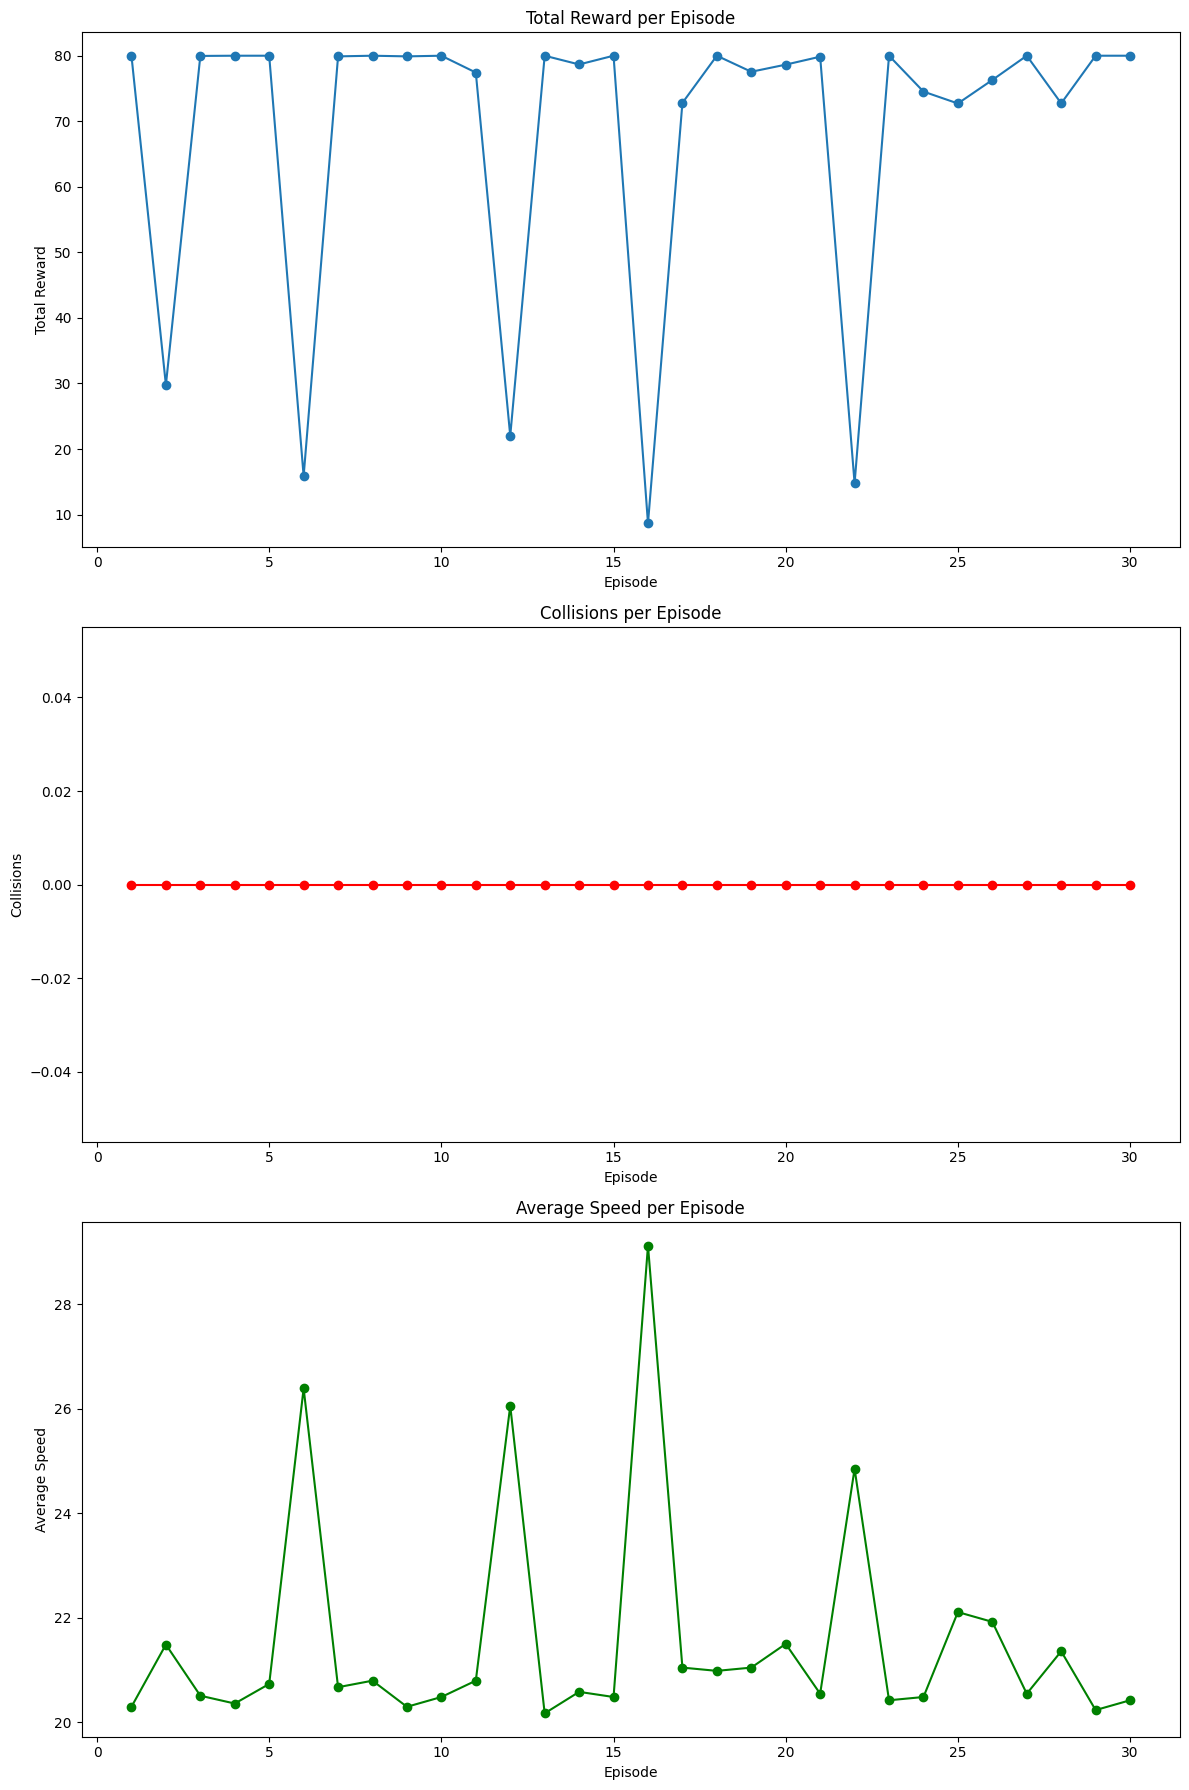

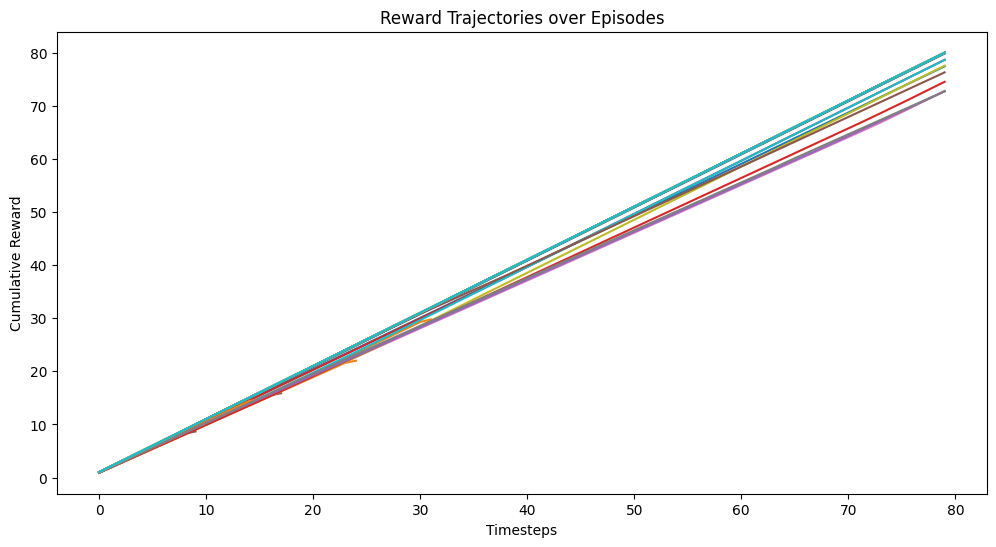

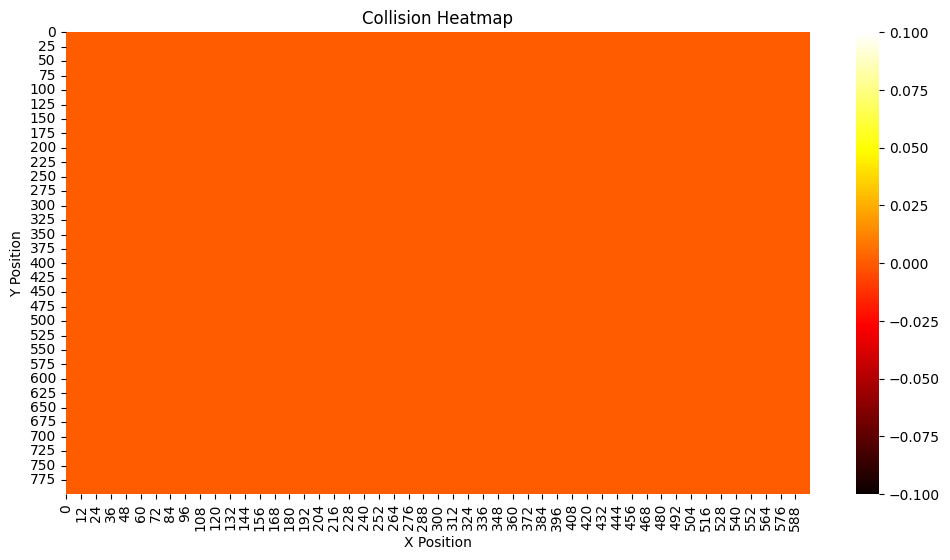

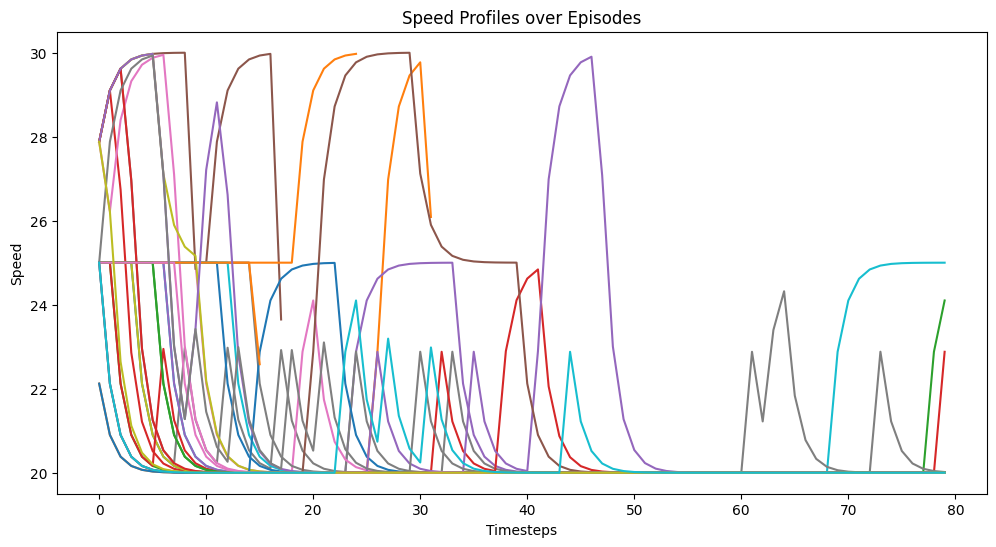

In [ ]:
num_episodes = 30
evaluation_metrics = {
    'episode': [],
    'total_reward': [],
    'collisions': [],
    'average_speed': [],
    'cumulative_rewards': [],
    'collision_positions': [],
    'speed_profiles': []
}

for episode in range(num_episodes):
    done = truncated = False
    obs, info = env.reset()
    total_reward = 0
    collisions = 0
    speeds = []
    cumulative_rewards = []
    collision_positions = []
    step_rewards = []
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        step_rewards.append(total_reward)
        speeds.append(info['speed'])
        if 'collision' in info and info['collision']:
            collisions += 1
            collision_positions.append(info['position'])
        env.render()
    evaluation_metrics['episode'].append(episode + 1)
    evaluation_metrics['total_reward'].append(total_reward)
    evaluation_metrics['collisions'].append(collisions)
    evaluation_metrics['average_speed'].append(np.mean(speeds))
    evaluation_metrics['cumulative_rewards'].append(step_rewards)
    evaluation_metrics['collision_positions'].append(collision_positions)
    evaluation_metrics['speed_profiles'].append(speeds)
    print(f"Total reward for episode {episode + 1}: {total_reward}")
env.close()

df_metrics = pd.DataFrame(evaluation_metrics)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(df_metrics['episode'], df_metrics['total_reward'], marker='o')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Total Reward per Episode')

axs[1].plot(df_metrics['episode'], df_metrics['collisions'], marker='o', color='r')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Collisions')
axs[1].set_title('Collisions per Episode')

axs[2].plot(df_metrics['episode'], df_metrics['average_speed'], marker='o', color='g')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Speed')
axs[2].set_title('Average Speed per Episode')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for rewards in df_metrics['cumulative_rewards']:
    plt.plot(rewards)
plt.xlabel('Timesteps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Trajectories over Episodes')
plt.show()

collision_heatmap = np.zeros((configuration['screen_width'], configuration['screen_height']))
for positions in df_metrics['collision_positions']:
    for pos in positions:
        collision_heatmap[int(pos[0]), int(pos[1])] += 1

plt.figure(figsize=(12, 6))
sns.heatmap(collision_heatmap, cmap='hot', cbar=True)
plt.title('Collision Heatmap')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

plt.figure(figsize=(12, 6))
for speeds in df_metrics['speed_profiles']:
    plt.plot(speeds)
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Speed Profiles over Episodes')
plt.show()


In [ ]:
from IPython.display import Video
video_path = "/content/drive/MyDrive/RL/highway_dqn2/video/rl-video-episode-0.mp4"
Video(video_path, embed=True)

# A2C DiscreteMetaAction Kinematics

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import A2C
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import seaborn as sns

configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "TimeToCollision"
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "collision_reward": -0.5,
    "reward_speed_range": [10, 20],
    "simulation_frequency": 15,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")

model = A2C('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]), verbose=2)

TRAIN = True
total_timesteps = 15000
if TRAIN:
    model.learn(total_timesteps=total_timesteps)
    model.save("/content/drive/MyDrive/RL/highway_a2c/model")
    del model

model = A2C.load("/content/drive/MyDrive/RL/highway_a2c/model", env=env)

env = RecordVideo(env, video_folder="/content/drive/MyDrive/RL/highway_a2c/video", episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
env.configure({"simulation_frequency": 30})


Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-0.mp4
Total reward for episode 1: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-1.mp4
Total reward for episode 2: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-2.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-2.mp4
Total reward for episode 3: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-3.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-3.mp4
Total reward for episode 4: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-4.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-4.mp4
Total reward for episode 5: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-5.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-5.mp4
Total reward for episode 6: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-6.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-6.mp4
Total reward for episode 7: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-7.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-7.mp4
Total reward for episode 8: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-8.mp4
Total reward for episode 9: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-9.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-9.mp4
Total reward for episode 10: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-10.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-10.mp4
Total reward for episode 11: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-11.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-11.mp4
Total reward for episode 12: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-12.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-12.mp4
Total reward for episode 13: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-13.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-13.mp4
Total reward for episode 14: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-14.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-14.mp4
Total reward for episode 15: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-15.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-15.mp4
Total reward for episode 16: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-16.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-16.mp4
Total reward for episode 17: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-17.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-17.mp4
Total reward for episode 18: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-18.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-18.mp4
Total reward for episode 19: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-19.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-19.mp4
Total reward for episode 20: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-20.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-20.mp4
Total reward for episode 21: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-21.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-21.mp4
Total reward for episode 22: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-22.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-22.mp4
Total reward for episode 23: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-23.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-23.mp4
Total reward for episode 24: 80.0
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-24.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-24.mp4
Total reward for episode 25: 6.106621950334943
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-25.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-25.mp4
Total reward for episode 26: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-26.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-26.mp4
Total reward for episode 27: 79.9
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-27.mp4
Total reward for episode 28: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-28.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-28.mp4
Total reward for episode 29: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-29.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-29.mp4
Total reward for episode 30: 80.0


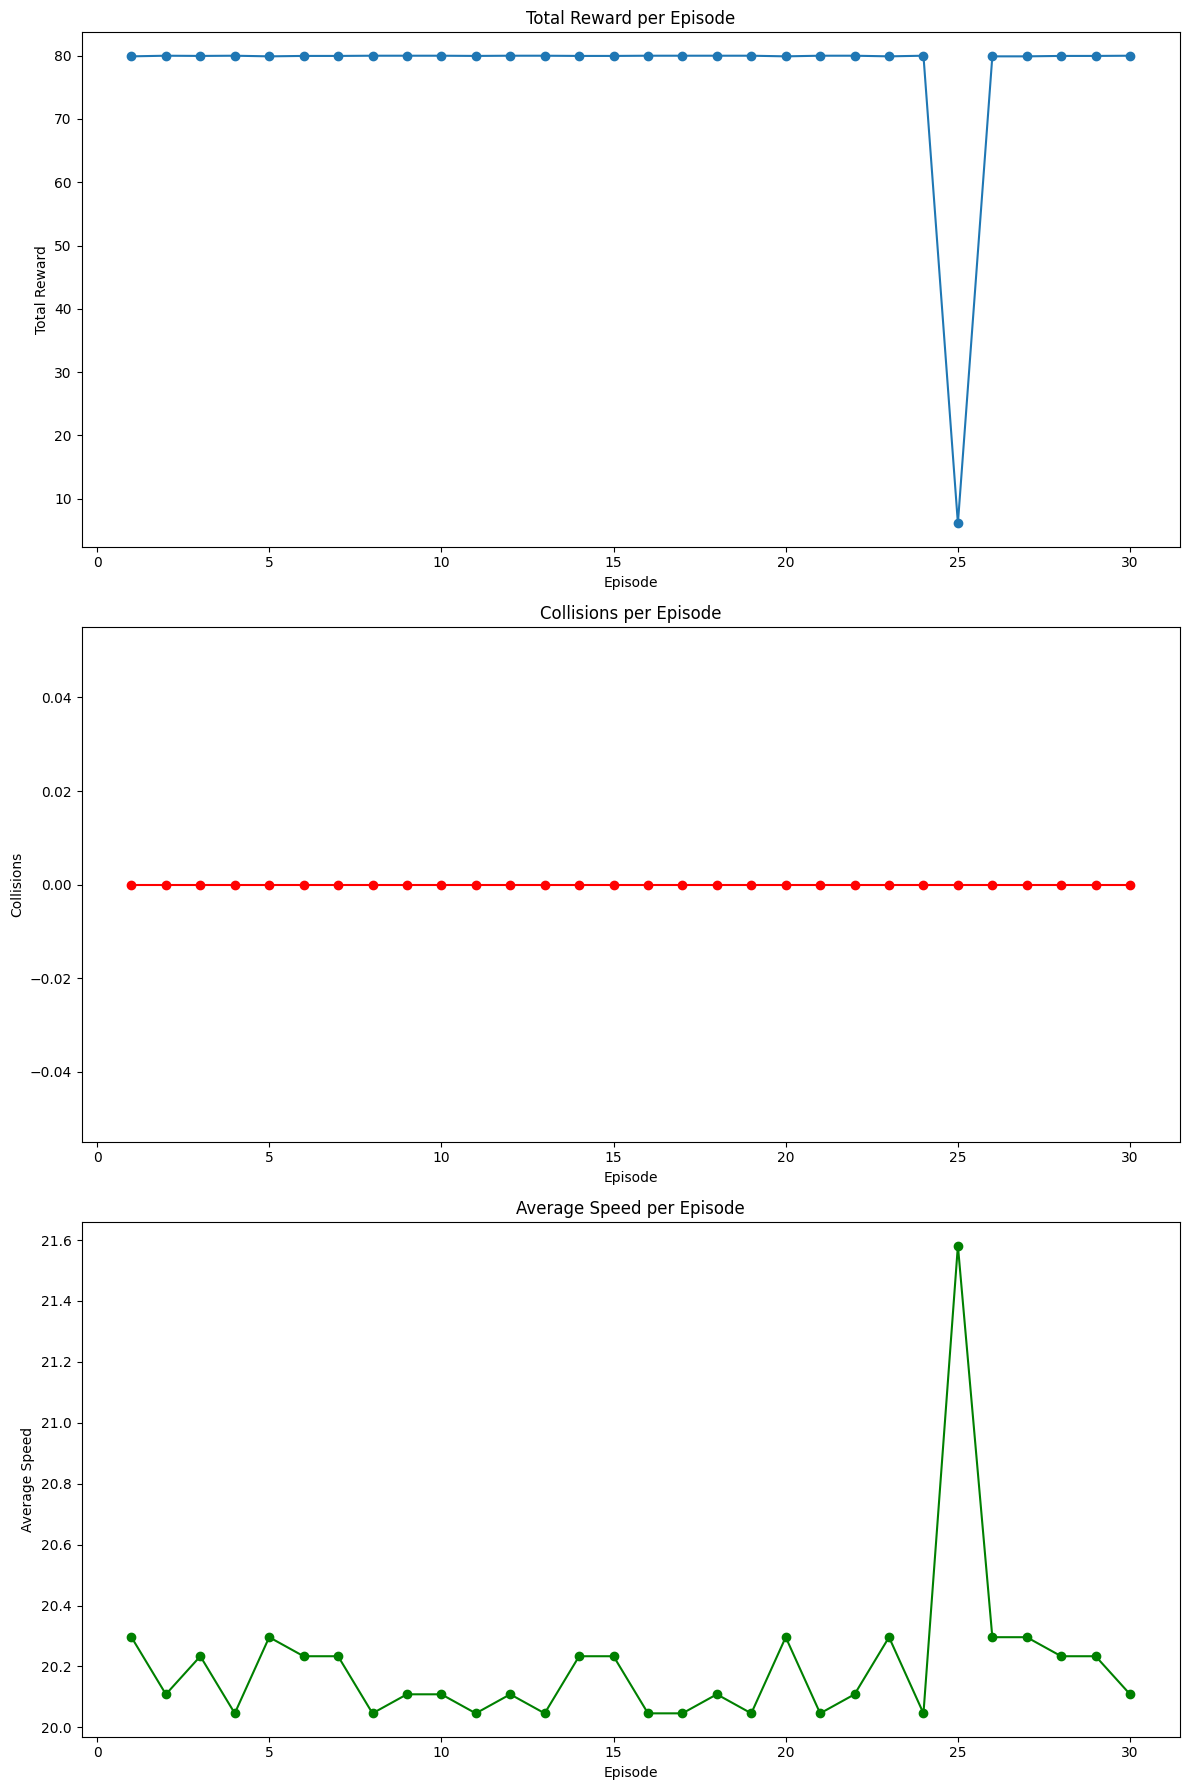

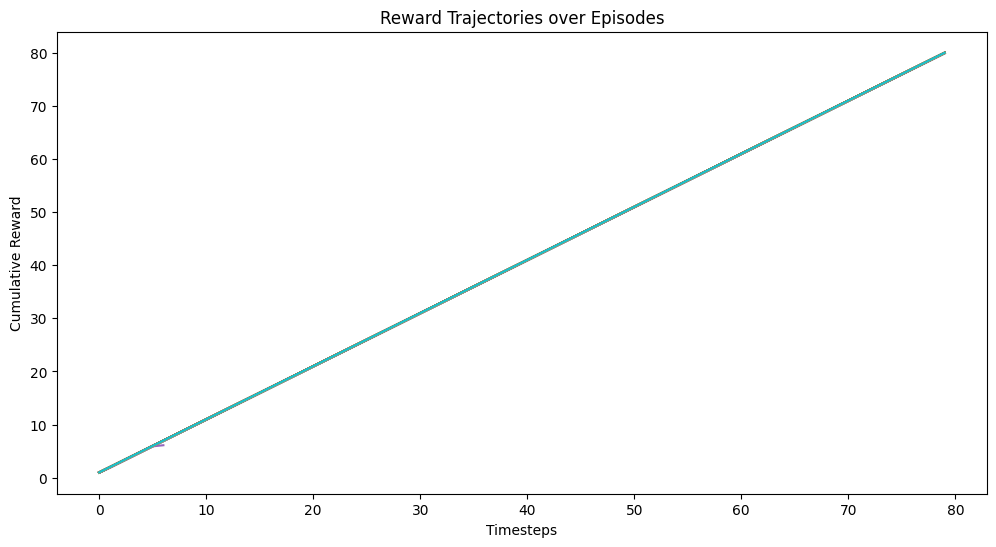

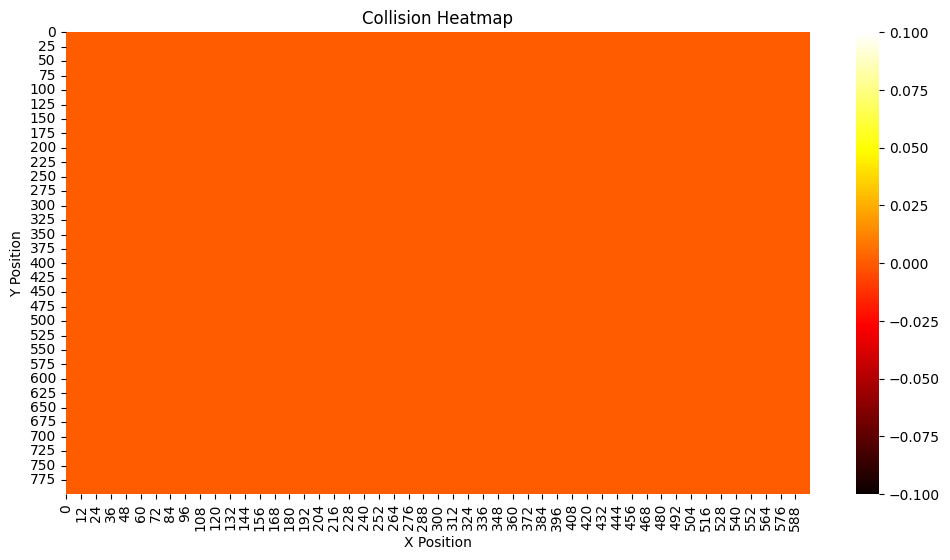

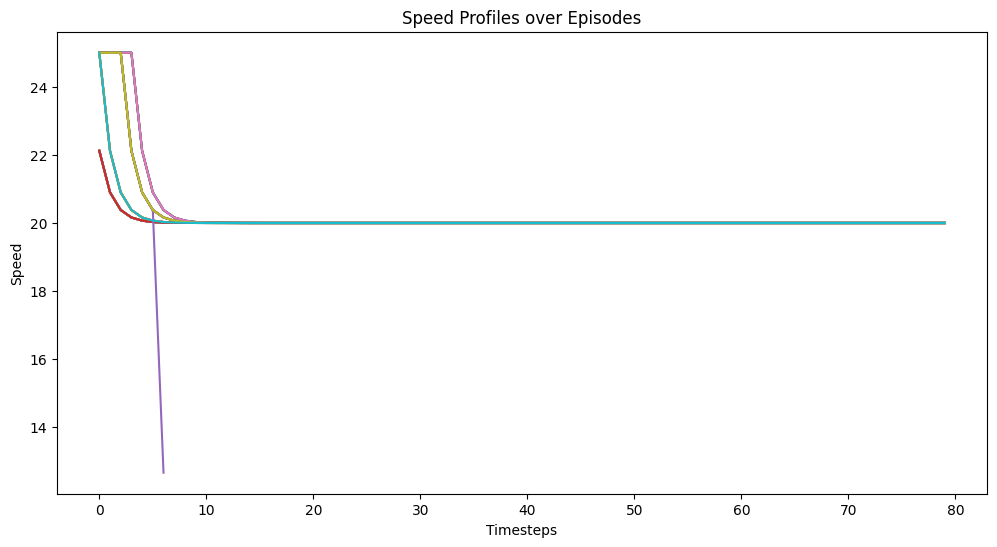

In [ ]:
num_episodes = 30
evaluation_metrics = {
    'episode': [],
    'total_reward': [],
    'collisions': [],
    'average_speed': [],
    'cumulative_rewards': [],
    'collision_positions': [],
    'speed_profiles': []
}

for episode in range(num_episodes):
    done = truncated = False
    obs, info = env.reset()
    total_reward = 0
    collisions = 0
    speeds = []
    cumulative_rewards = []
    collision_positions = []
    step_rewards = []
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        step_rewards.append(total_reward)
        speeds.append(info['speed'])
        if 'collision' in info and info['collision']:
            collisions += 1
            collision_positions.append(info['position'])
        env.render()
    evaluation_metrics['episode'].append(episode + 1)
    evaluation_metrics['total_reward'].append(total_reward)
    evaluation_metrics['collisions'].append(collisions)
    evaluation_metrics['average_speed'].append(np.mean(speeds))
    evaluation_metrics['cumulative_rewards'].append(step_rewards)
    evaluation_metrics['collision_positions'].append(collision_positions)
    evaluation_metrics['speed_profiles'].append(speeds)
    print(f"Total reward for episode {episode + 1}: {total_reward}")
env.close()

df_metrics = pd.DataFrame(evaluation_metrics)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(df_metrics['episode'], df_metrics['total_reward'], marker='o')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Total Reward per Episode')

axs[1].plot(df_metrics['episode'], df_metrics['collisions'], marker='o', color='r')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Collisions')
axs[1].set_title('Collisions per Episode')

axs[2].plot(df_metrics['episode'], df_metrics['average_speed'], marker='o', color='g')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Speed')
axs[2].set_title('Average Speed per Episode')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for rewards in df_metrics['cumulative_rewards']:
    plt.plot(rewards)
plt.xlabel('Timesteps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Trajectories over Episodes')
plt.show()

collision_heatmap = np.zeros((configuration['screen_width'], configuration['screen_height']))
for positions in df_metrics['collision_positions']:
    for pos in positions:
        collision_heatmap[int(pos[0]), int(pos[1])] += 1

plt.figure(figsize=(12, 6))
sns.heatmap(collision_heatmap, cmap='hot', cbar=True)
plt.title('Collision Heatmap')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

plt.figure(figsize=(12, 6))
for speeds in df_metrics['speed_profiles']:
    plt.plot(speeds)
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Speed Profiles over Episodes')
plt.show()


In [ ]:
from IPython.display import Video
video_path = "/content/drive/MyDrive/RL/highway_a2c/video/rl-video-episode-1.mp4"
Video(video_path, embed=True)

# SAC Continous Kinematics

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import highway_env
from stable_baselines3 import DQN, A2C, DDPG, PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import time
import imageio

results = []

def optimize_hyperparameters(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    buffer_size = trial.suggest_int('buffer_size', 5000, 30000)
    learning_starts = trial.suggest_int('learning_starts', 200, 1000)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    gamma = trial.suggest_uniform('gamma', 0.70, 0.99)
    train_freq = trial.suggest_int('train_freq', 1, 10)
    gradient_steps = trial.suggest_int('gradient_steps', 1, 10)

    configuration = {
        "lanes_count": 4,
        "vehicles_count": 50,
        "duration": 120,
        "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
        "initial_spacing": 2,
        "observation": {
        "type": "Kinematics"
        },
        "action": {
            "type": "ContinuousAction",
        },
        "collision_reward": -0.5,
        "reward_speed_range": [10, 20],
        "simulation_frequency": 15,
        "policy_frequency": 2,
        "screen_width": 800,
        "screen_height": 600,
        "centering_position": [0.5, 0.5],
        "scaling": 5,
        "show_trajectories": False,
        "render_agent": True,
        "offscreen_rendering": False
    }

    env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
    env = DummyVecEnv([lambda: env])

    model = SAC('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=learning_rate,
                buffer_size=buffer_size,
                learning_starts=learning_starts,
                batch_size=batch_size,
                gamma=gamma,
                train_freq=train_freq,
                gradient_steps=gradient_steps,
                verbose=2)

    model.learn(total_timesteps=1000)
    rewards = []
    for _ in range(1):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            if len(step_result) == 4:
                obs, reward, done, info = step_result
                truncated = False
            else:
                obs, reward, done, truncated, info = step_result
            total_reward += reward
            if done or truncated:
                break
        rewards.append(total_reward)
    average_reward = np.mean(rewards)

    results.append({
        "model": "SAC",
        "learning_rate": learning_rate,
        "buffer_size": buffer_size,
        "learning_starts": learning_starts,
        "batch_size": batch_size,
        "gamma": gamma,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "average_reward": average_reward
    })

    return average_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_hyperparameters, n_trials=30)
best_params = study.best_params

results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hyperparameter_tuning_results3.csv", index=False)




[I 2024-06-14 22:56:26,849] A new study created in memory with name: no-name-da4a1b8d-53e0-47f1-8329-0fc359f2832e
<ipython-input-30-a405aaa286c4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-30-a405aaa286c4>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.70, 0.99)


Using cpu device


[W 2024-06-14 22:56:56,576] Trial 0 failed with parameters: {'learning_rate': 0.0016324535478472644, 'buffer_size': 24892, 'learning_starts': 379, 'batch_size': 64, 'gamma': 0.8529497531182777, 'train_freq': 10, 'gradient_steps': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-30-a405aaa286c4>", line 65, in optimize_hyperparameters
    model.learn(total_timesteps=1000)
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/sac/sac.py", line 307, in learn
    return super().learn(
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/off_policy_algorithm.py", line 328, in learn
    rollout = self.collect_rollouts(
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/off_policy_algorithm.py", line 560, in collect_rollouts
    new_obs, rewards

KeyboardInterrupt: 

In [ ]:
from stable_baselines3 import DQN, SAC, A2C, DDPG
total_timesteps = 30000
num_episodes = 5
TRAIN = True

configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics"
    },
    "action": {
        "type": "ContinuousAction",
    },
    "collision_reward": -0.5,
    "reward_speed_range": [10, 20],
    "simulation_frequency": 30,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False,
    "render_mode": "rgb_array"
}

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")

model = SAC('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]),
    learning_rate=0.00029089088495563175,
    buffer_size=5529,
    learning_starts=288,  r
    batch_size=64,
    gamma=0.8466870819467923,
    train_freq=2,
    gradient_steps=4,
    verbose=2
)



if TRAIN:
    model.learn(total_timesteps=total_timesteps)
    model.save("/content/drive/MyDrive/rf_learning_model/sac_model")
    del model

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
env = RecordVideo(env, video_folder="/content/drive/MyDrive/rf_learning_model/sac_video", episode_trigger=lambda e: True)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80       |
|    ep_rew_mean     | 6.69     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2        |
|    time_elapsed    | 107      |
|    total_timesteps | 320      |
| train/             |          |
|    actor_loss      | -2.55    |
|    critic_loss     | 0.1      |
|    ent_coef        | 0.983    |
|    ent_coef_loss   | -0.0562  |
|    learning_rate   | 0.000291 |
|    n_updates       | 60       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80       |
|    ep_rew_mean     | 6.45     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2        |
|    time_elapsed    | 220      |
|    total_timesteps | 640      |
| train/             |

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/rf_learning_model folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-0.mp4
Total reward for episode 1: 79.85999497479767
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-1.mp4
Total reward for episode 2: 77.93070038819802
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-2.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-2.mp4
Total reward for episode 3: 79.59721460934671
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-3.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-3.mp4
Total reward for episode 4: 79.99028368037283
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-4.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-4.mp4
Total reward for episode 5: 79.33825936431909
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-5.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-5.mp4
Total reward for episode 6: 72.54371641347707
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-6.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-6.mp4
Total reward for episode 7: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-7.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-7.mp4
Total reward for episode 8: 79.83333333333334
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-8.mp4
Total reward for episode 9: 79.9
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-9.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-9.mp4
Total reward for episode 10: 79.72245399704785
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-10.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-10.mp4
Total reward for episode 11: 78.55970016131596
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-11.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-11.mp4
Total reward for episode 12: 77.64536016662034
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-12.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-12.mp4
Total reward for episode 13: 78.47928930688666
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-13.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-13.mp4
Total reward for episode 14: 79.65678767505123
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-14.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-14.mp4
Total reward for episode 15: 79.93333333333334
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-15.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-15.mp4
Total reward for episode 16: 80.0
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-16.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-16.mp4
Total reward for episode 17: 77.3413566307917
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-17.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-17.mp4
Total reward for episode 18: 79.56970450883621
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-18.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-18.mp4
Total reward for episode 19: 79.93333333333334
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-19.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-19.mp4
Total reward for episode 20: 78.56302077927677
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-20.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-20.mp4
Total reward for episode 21: 5.9333333333333345


Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-21.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-21.mp4
Total reward for episode 22: 79.61618684809932
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-22.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-22.mp4
Total reward for episode 23: 79.9
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-23.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-23.mp4
Total reward for episode 24: 79.83160394678565
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-24.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-24.mp4
Total reward for episode 25: 79.7660432436998
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-25.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-25.mp4
Total reward for episode 26: 79.03839155621242
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-26.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-26.mp4
Total reward for episode 27: 78.7662459320149
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-27.mp4
Total reward for episode 28: 79.6414755524858
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-28.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-28.mp4
Total reward for episode 29: 79.96666666666667
Moviepy - Building video /content/drive/MyDrive/rf_learning_model/rl-video-episode-29.mp4.
Moviepy - Writing video /content/drive/MyDrive/rf_learning_model/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rf_learning_model/rl-video-episode-29.mp4
Total reward for episode 30: 80.0


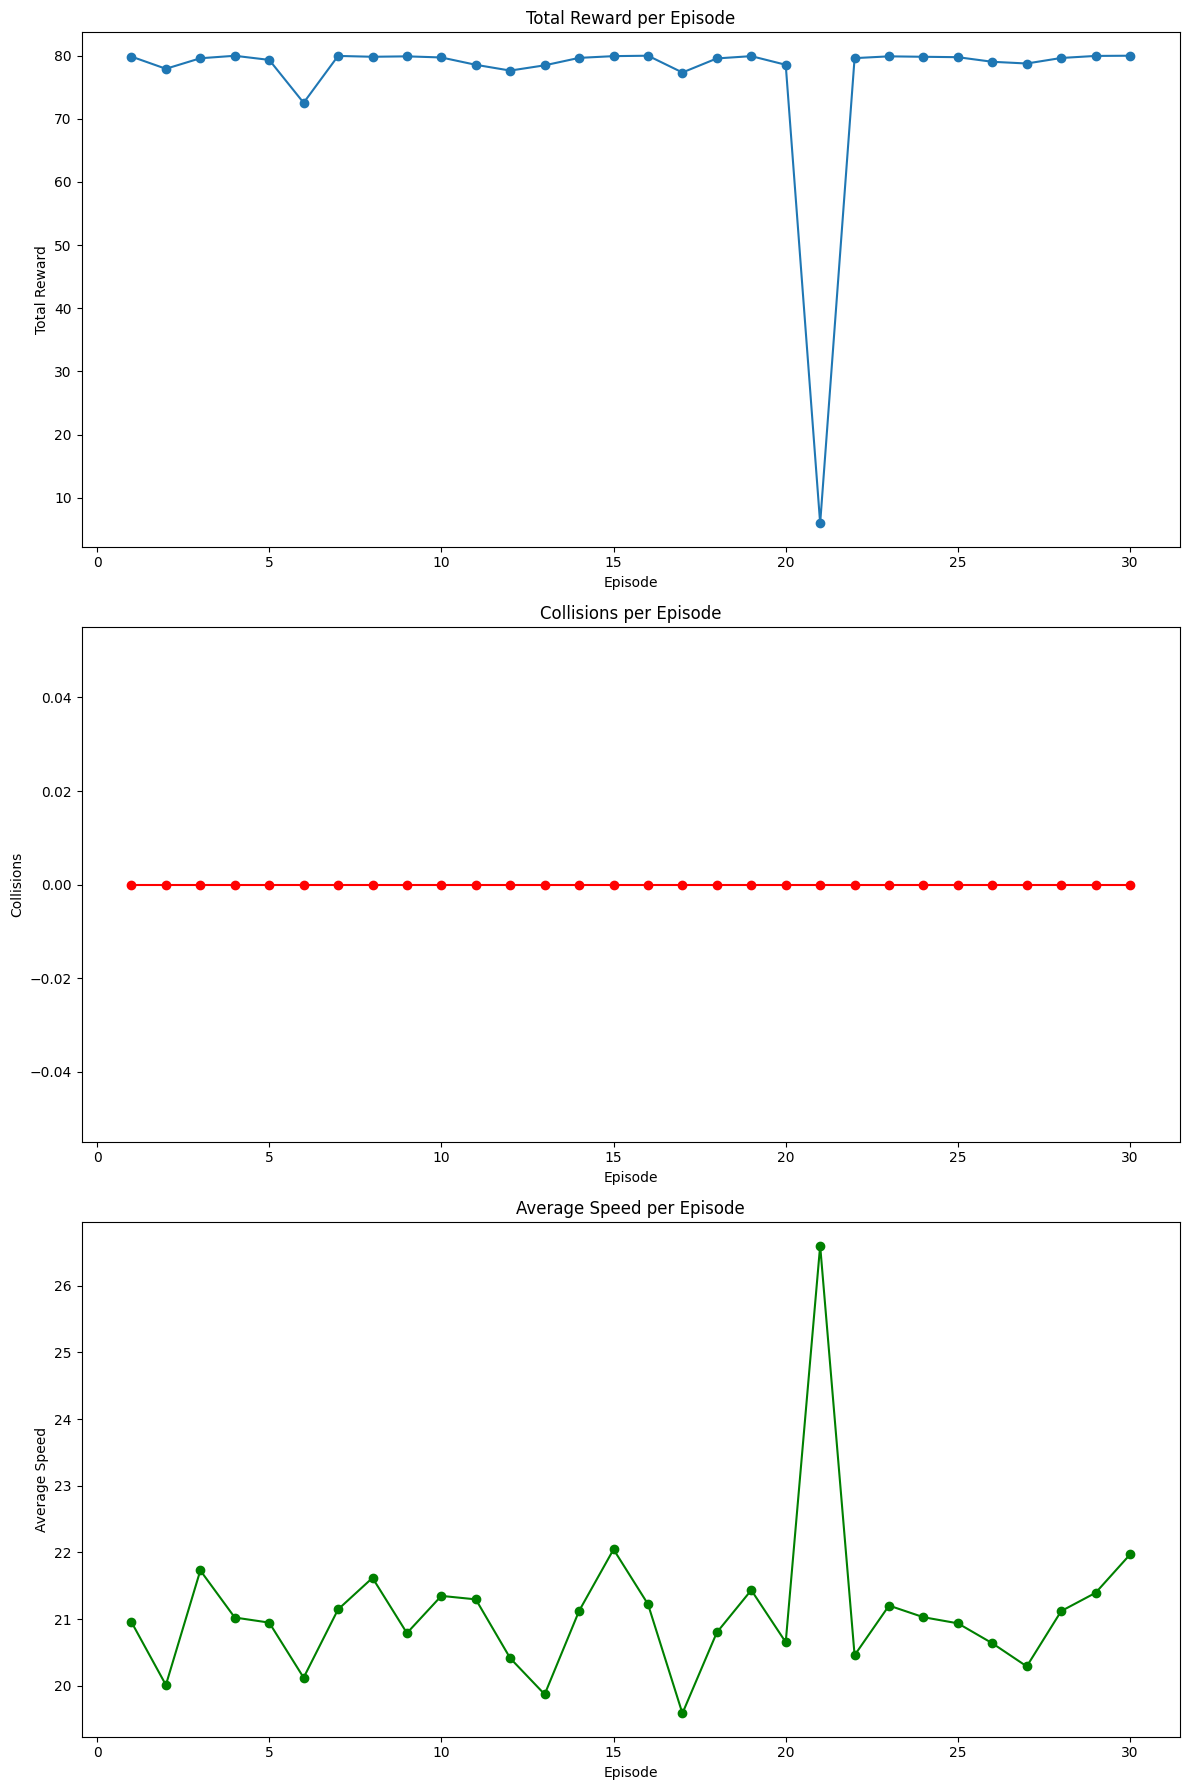

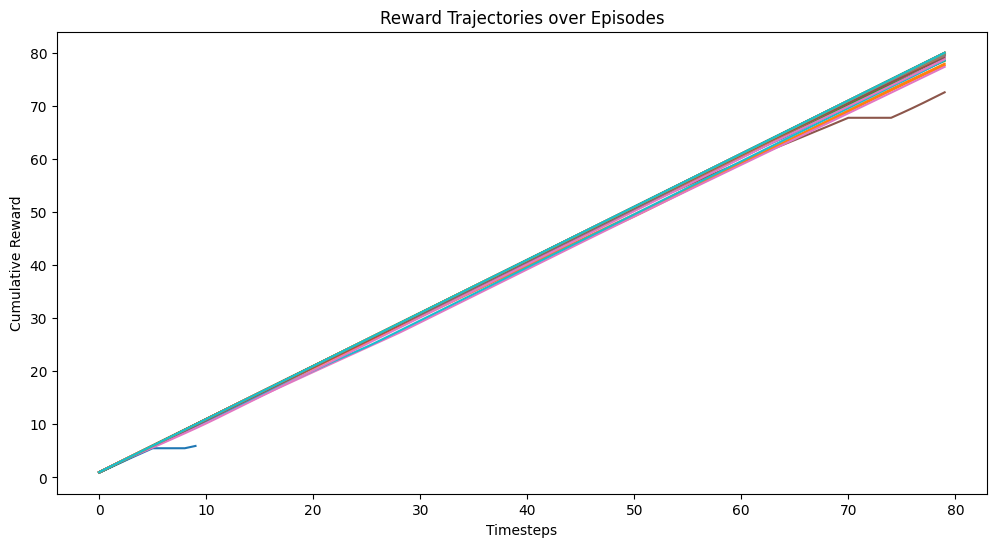

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
model = SAC.load("/content/drive/MyDrive/rf_learning_model.zip", env=env)

num_episodes = 30
evaluation_metrics = {
    'episode': [],
    'total_reward': [],
    'collisions': [],
    'average_speed': [],
    'cumulative_rewards': [],
    'collision_positions': [],
    'speed_profiles': []
}

for episode in range(num_episodes):
    done = truncated = False
    obs, info = env.reset()
    total_reward = 0
    collisions = 0
    speeds = []
    cumulative_rewards = []
    collision_positions = []
    step_rewards = []
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        step_rewards.append(total_reward)
        speeds.append(info['speed'])
        if 'collision' in info and info['collision']:
            collisions += 1
            collision_positions.append(info['position'])
        env.render()
    evaluation_metrics['episode'].append(episode + 1)
    evaluation_metrics['total_reward'].append(total_reward)
    evaluation_metrics['collisions'].append(collisions)
    evaluation_metrics['average_speed'].append(np.mean(speeds))
    evaluation_metrics['cumulative_rewards'].append(step_rewards)
    evaluation_metrics['collision_positions'].append(collision_positions)
    evaluation_metrics['speed_profiles'].append(speeds)
    print(f"Total reward for episode {episode + 1}: {total_reward}")
env.close()

df_metrics = pd.DataFrame(evaluation_metrics)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(df_metrics['episode'], df_metrics['total_reward'], marker='o')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Total Reward per Episode')

axs[1].plot(df_metrics['episode'], df_metrics['collisions'], marker='o', color='r')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Collisions')
axs[1].set_title('Collisions per Episode')

axs[2].plot(df_metrics['episode'], df_metrics['average_speed'], marker='o', color='g')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Speed')
axs[2].set_title('Average Speed per Episode')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for rewards in df_metrics['cumulative_rewards']:
    plt.plot(rewards)
plt.xlabel('Timesteps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Trajectories over Episodes')
plt.show()

collision_heatmap = np.zeros((configuration['screen_width'], configuration['screen_height']))
for positions in df_metrics['collision_positions']:
    for pos in positions:
        collision_heatmap[int(pos[0]), int(pos[1])] += 1

plt.figure(figsize=(12, 6))
sns.heatmap(collision_heatmap, cmap='hot', cbar=True)
plt.title('Collision Heatmap')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

plt.figure(figsize=(12, 6))
for speeds in df_metrics['speed_profiles']:
    plt.plot(speeds)
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Speed Profiles over Episodes')
plt.show()


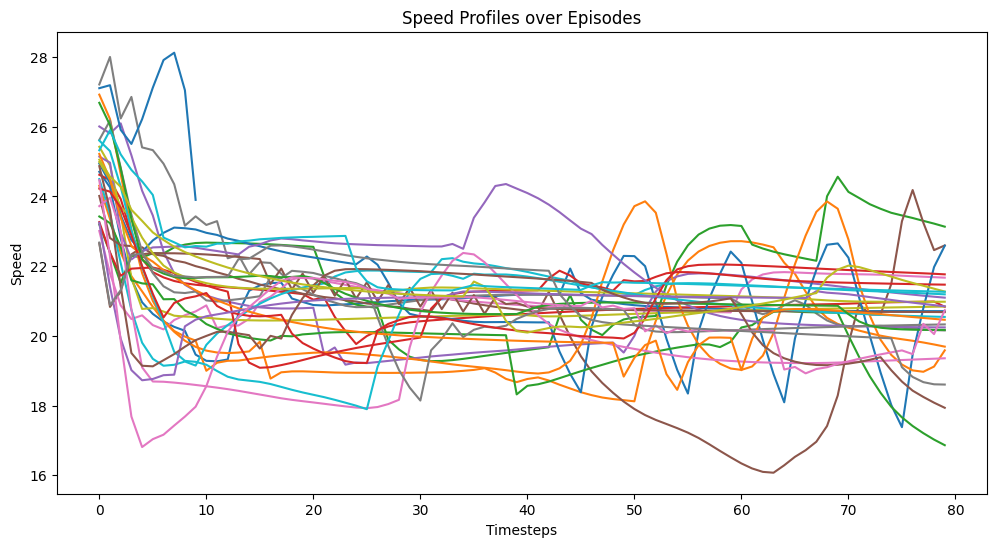

In [ ]:
plt.figure(figsize=(12, 6))
for speeds in df_metrics['speed_profiles']:
    plt.plot(speeds)
plt.xlabel('Timesteps')
plt.ylabel('Speed')
plt.title('Speed Profiles over Episodes')
plt.show()

In [ ]:
from IPython.display import Video
video_path = "/content/drive/MyDrive/rf_learning_model/rl-video-episode-29.mp4"
Video(video_path, embed=True)

# Custom Reward Trial

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DDPG
import numpy as np
import highway_env

total_timesteps = 10000
num_episodes = 5
TRAIN = True

import numpy as np

def custom_reward(env):
    ego_vehicle = env.unwrapped.vehicle

    # Define parameters
    safe_distance = 5
    appropriate_distance_range = [3, 5]
    quick_y_movement_threshold = 2

    # Initialize rewards and penalties
    speed_reward = 0
    distance_reward = 0
    slow_speed_penalty = 0
    quick_y_movement_penalty = 0

    # Find the front vehicle
    front_vehicle = None
    min_distance = float('inf')
    for vehicle in env.unwrapped.road.vehicles:
        if vehicle.position[0] > ego_vehicle.position[0]:  # Only consider vehicles in front
            distance = np.linalg.norm(vehicle.position - ego_vehicle.position)
            if distance < min_distance:
                min_distance = distance
                front_vehicle = vehicle

    # Reward for maintaining an appropriate distance with the front vehicle
    if front_vehicle and appropriate_distance_range[0] <= min_distance <= appropriate_distance_range[1]:
        distance_reward += 0.5  # Assign a reward for maintaining the appropriate distance

    # Reward for moving faster if there is no vehicle within the safe distance
    if all(np.linalg.norm(vehicle.position - ego_vehicle.position) > safe_distance for vehicle in env.unwrapped.road.vehicles):
        speed_reward += 0.5 * ego_vehicle.speed  # Increased the factor for speed reward

    # Penalize for moving too slow but still above the threshold
    if ego_vehicle.speed < appropriate_distance_range[0]:
        slow_speed_penalty -= 0.2 * (appropriate_distance_range[0] - ego_vehicle.speed)  # Adjust the factor as needed

    # Penalize for making a very quick movement in the y-axis
    if abs(ego_vehicle.velocity[1]) > quick_y_movement_threshold:
        quick_y_movement_penalty -= 0.5 * abs(ego_vehicle.velocity[1])  # Adjust the factor as needed

    # Combine all rewards and penalties
    custom_reward = speed_reward + distance_reward + slow_speed_penalty + quick_y_movement_penalty
    return custom_reward


# Define a custom wrapper
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env, use_custom_reward=True):
        super(CustomRewardWrapper, self).__init__(env)
        self.use_custom_reward = use_custom_reward

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        if self.use_custom_reward:
            reward += custom_reward(self.env)
        return obs, reward, done, truncated, info




In [ ]:
from stable_baselines3 import DQN, SAC, A2C, DDPG
total_timesteps = 50000
num_episodes = 5
TRAIN = True

configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics"
    },
    "action": {
        "type": "ContinuousAction",
    },
    "collision_reward": -1,
    "reward_speed_range": [15, 25],
    "simulation_frequency": 15,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False,
    "render_mode": "rgb_array"
}

# With custom rewards
env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
env = CustomRewardWrapper(env, use_custom_reward=True)

model = DDPG('MlpPolicy', env, policy_kwargs=dict(net_arch=[256, 256]),
    learning_rate=5e-4,
    buffer_size=50000,
    learning_starts=200,
    batch_size=256, e
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    verbose=2,
)

if TRAIN:
    model.learn(total_timesteps=total_timesteps)
    model.save("/content/highway_ddpg1/model")
    del model

env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
env = CustomRewardWrapper(env, use_custom_reward=False)  # No custom rewards
env = RecordVideo(env, video_folder="/content/highway_ddpg1/videos", episode_trigger=lambda e: True)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80       |
|    ep_rew_mean     | 4.32     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3        |
|    time_elapsed    | 81       |
|    total_timesteps | 320      |
| train/             |          |
|    actor_loss      | -0.119   |
|    critic_loss     | 0.0174   |
|    learning_rate   | 0.0005   |
|    n_updates       | 119      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72.4     |
|    ep_rew_mean     | 7.58     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3        |
|    time_elapsed    | 147      |
|    total_timesteps | 579      |
| train/             |          |
|    actor_loss      | -0.428   |
|    critic_loss     |

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path '/content/highway_ddpg1' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
configuration = {
    "lanes_count": 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {
        "type": "Kinematics"
    },
    "action": {
        "type": "ContinuousAction",
    },
    "collision_reward": -1,
    "reward_speed_range": [15, 25],
    "simulation_frequency": 60,
    "policy_frequency": 2,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False,
    "render_mode": "rgb_array"
}
env = gym.make('highway-v0', config=configuration, render_mode="rgb_array")
env = RecordVideo(env, video_folder="/content/highway_ddpg/videos", episode_trigger=lambda e: True)
model = DDPG.load("/content/highway_ddpg1/model", env=env)

for episode in range(num_episodes):
    done = truncated = False
    reset_result = env.reset()
    if isinstance(reset_result, tuple) and len(reset_result) == 2:
        obs, info = reset_result
    else:
        obs = reset_result
    total_reward = 0
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        step_result = env.step(action)
        if len(step_result) == 4:
            obs, reward, done, info = step_result
            truncated = False
        else:
            obs, reward, done, truncated, info = step_result
        total_reward += reward
        env.render()
    print(f"Total reward for episode {episode + 1}: {total_reward}")

env.close()

from IPython.display import Video
video_path = "/content/highway_ddpg1/videos/rl-video-episode-4.mp4"
Video(video_path, embed=True)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Moviepy - Building video /content/highway_ddpg/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/highway_ddpg/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/highway_ddpg/videos/rl-video-episode-0.mp4
Total reward for episode 1: 43.745938387644905
Moviepy - Building video /content/highway_ddpg/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/highway_ddpg/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/highway_ddpg/videos/rl-video-episode-1.mp4
Total reward for episode 2: 44.34519865614744
Moviepy - Building video /content/highway_ddpg/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/highway_ddpg/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/highway_ddpg/videos/rl-video-episode-2.mp4
Total reward for episode 3: 50.2797518376118
Moviepy - Building video /content/highway_ddpg/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /content/highway_ddpg/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/highway_ddpg/videos/rl-video-episode-3.mp4
Total reward for episode 4: 52.27698128224447
Moviepy - Building video /content/highway_ddpg/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/highway_ddpg/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/highway_ddpg/videos/rl-video-episode-4.mp4
Total reward for episode 5: 47.37186323887796
